In [ ]:
# CNN

In [2]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime, time
import os, sys
import tqdm
import gc
import random
from multiprocessing import Process
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float16'

In [3]:
# INIT
# PART 1
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 10001, 1000))
number_samples = [120, 220] 
# number_samples = [210]
# number_samples = [4096, 4915, 5734, 6554, 7373, 8192]

# cnn_type = "classification"  # {"classification", "regression"}
validation_size, noise_floor = 0.1, -90.0#-110.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y, number_image_channels, su_szie = 100, 100, 6, 10  # su_size:30 for 1000, 10 for 100
cell_size = int(max(max_x, max_y)/10)
pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
intensity_degradation, slope = 'log', 5  # 'log', 'linear', slope 3 for 1000, 5 for 100
max_pus_num, max_sus_num = 4, 1
propagation_model = 'testbed' # 'splat', 'log', 'testbed'
noise, std = False, 1 # False for splat
K_SIZE = 10 # K-fold
if su_shape == 'circle':
    su_param = Circle(su_szie)
elif su_shape == 'square':
    su_param = Square(su_szie)
else:
    su_param = None
    
sensors = True
if sensors:
    sensors_num, sensors_selected_num = 17, 12
    sensors_file_path = "rsc/sensors/10"  + "/" + str(sensors_num) + "/sensors"
# num_pus = (data_reg.shape[1] - 3)//3

# PART 2
number_of_proccessors = 5
memory_size_allowed = 4 # in Gigabyte
float_size = 0
if float_memory_used == "float16":
    float_size = 16
elif float_memory_used == "float" or "float32":
    float_size = 32
elif float_memory_used == "float8":
    float_size = 8

number_image_channels = 7 if sensors else 5


batch_size = int(memory_size_allowed / (max_x * max_y * number_image_channels * float_size/(8 * 1024 ** 3)))


dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (intensity_degradation + '_' + str(slope))) + (
    "/" + str(sensors_num) + "sensors" if sensors else "/pus") + "/images"

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [4]:
image_dir

'ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/images'

In [6]:
# LOAD DATA
num_columns = (sensors_num if sensors else max_pus_num * 3 + 1) + max_sus_num * 3 + 1
cols = [i for i in range(num_columns)]
dataset_name = "su_ss_calibrate_shuffled"
# max_dataset_name = "dynamic_pus_max_power_60000_min10_max20PUs_1SUs_square100grid_splat_2020_06_28_13_45.txt"
with open('/'.join(image_dir.split('/')[:-1]) + '/datasets' + dtime + '.txt', 'w') as set_file:
    set_file.write(dataset_name + "\n")
#     set_file.write(max_dataset_name)

dataframe = pd.read_csv('ML/data/testbed/'
                        + dataset_name, delimiter=',', header=None, names=cols)
# dataframe_max = pd.read_csv('../../../java_workspace/research/spectrum_allocation/resources/data/'
#                             + max_dataset_name, delimiter=',', header=None)

dataframe.reset_index(drop=True, inplace=True)
# dataframe_max.reset_index(drop=True, inplace=True)
# dataframe_max[dataframe_max.shape[1] - 1] = dataframe_max[dataframe_max.shape[1] - 1].astype(float)

# dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-1:]]], axis=1,
#                         ignore_index=True)

# idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
# dataframe_tot.drop(idx, inplace=True)
# dataframe = dataframe.sample(frac=1).reset_index(drop=True)
data_reg = dataframe.values
data_reg[data_reg < noise_floor] = noise_floor
# data_reg = np.concatenate((dataframe_tot.values[:, 0:dataframe_tot.shape[1]-3], 
#                            dataframe_tot.values[:, dataframe_tot.shape[1]-1:dataframe_tot.shape[1]]), axis=1)
# data_class = dataframe_tot.values[:, 0:dataframe_tot.shape[1]-1]
# y_class_power = dataframe_tot.values[:, -1]

if sensors:
    sensors_location = []
    with open(sensors_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(' ')
            sensors_location.append(Point(int(float(line[0]) * cell_size), int(float(line[1])) * cell_size))
# if not sensors:
#     for sample_idx in range(data_reg.shape[0]):
#         data_reg[sample_idx][-1] = data_reg[sample_idx][int(data_reg[sample_idx][0]) * 3 + 3]
        
del dataframe

In [7]:
data_reg.shape

(519, 21)

In [11]:
# pu conversion
for i in range(data_reg.shape[0]):
    num_pus = int(data_reg[i][0])
    data_reg[i][num_pus*3 + 2: num_pus*3 + 5] = data_reg[i][num_pus*3 + 1: num_pus*3 + 4]
    data_reg[i][num_pus*3+1] = 1
    if num_pus == max_pus_num:
        continue
    data_reg[i][-1] = data_reg[i][num_pus*3+4]
np.random.shuffle(data_reg)
np.savetxt('ML/data/testbed/su_pu_calibrate_shuffled',data_reg, delimiter=",", fmt="%.1f")

In [7]:
# sensor conversion
for i in range(data_reg.shape[0]):
    for j in range(data_reg.shape[1]-1):
        data_reg[i][j] = float(data_reg[i][j])
    num_ss = 17
    data_reg[i][num_ss+1:num_ss+4] = data_reg[i][num_ss:num_ss+3]
    data_reg[i][num_ss] = 1
np.random.shuffle(data_reg)
np.savetxt('ML/data/testbed/su_ss_calibrate_shuffled',data_reg, delimiter=",", fmt="%.5f")

In [14]:
data_reg = np.concatenate((data_reg[:150][:], data_reg[151:][:]), axis=0)
np.savetxt('ML/data/testbed/su_ss_calibrate_shuffled',data_reg, delimiter=",", fmt="%.5f")

In [4]:
sensor_selected_idx = random.sample(range(sensors_num), sensors_selected_num)

In [5]:
sensor_selected_idx

[9, 16, 12, 6, 4, 11, 7, 14, 15, 0, 2, 5]

In [8]:
data_reg.shape

(520, 17)

In [9]:
data_reg[155]

array([ 3. ,  3. ,  3. , 62. ,  0. ,  8. , 35. ,  7. ,  9. , 28. ,  6. ,
        4. , 36.7,  nan,  nan,  nan,  nan])

In [ ]:
data_reg = np.concatenate((data_reg[:,:2500], np.ones((4000, 1)), data_reg[:, 2500:2504],
               data_reg[:, 2505:]), axis=1)

In [ ]:
data_reg[0, sensors_num:]

In [ ]:
data_reg = data_reg[:][:30000]

In [ ]:
data_reg[512:1024, :] = data_reg[:512, :]

In [ ]:
data_reg[4096:8192, sensors_num:] = data_reg[:4096, sensors_num:]

In [ ]:
print(data_reg[10, :])
print(data_reg[266, :])

In [10]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def get_pu_param(pu_shape: str, intensity_degradation: str, pu_p: float, noise_floor: float, slope: float):
    pu_param = None
    if pu_shape == 'circle':
        if intensity_degradation == "linear":
            pu_param = Circle(int((pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Circle(int(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'square':
        if intensity_degradation == "linear":
            pu_param = Square(int(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Square(int(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'point':
        pu_param = None
    else:
        raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
    return pu_param

def create_image(data, slope, sensors_num, style="raw_power_z_score", noise_floor=-90, pu_shape= 'circle', pu_param=None, 
                 su_shape='circle', su_param=None, intensity_degradation="log", max_pu_power: float=0):  
    # style = {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_min_max_norm":
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        
        # creating pu matrix
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        if not sensors:
            pus_num = int(data[0])
            pus_cluster = [(7, 7), (7, 2), (2, 2), (2, 7)]
#             print(pus_num)
            for pu_i in range(pus_num):
                pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1]))) 
                pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2])))
                pus_dist_cluster = [math.sqrt((pu_x - x)**2 + (pu_y - y)**2) for x,y in pus_cluster]
                pu_p = data[pu_i * 3 + 3]
                pu_channel_idx = pus_dist_cluster.index(min(pus_dist_cluster))
                pu_x *= cell_size
                pu_y *= cell_size
#                 print(pu_x, pu_y, pu_p)
                if pu_param is None:
                    pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
                else:
                    pu_param_p = pu_param
                points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[0][pu_channel_idx][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[0][pu_channel_idx][point.p.x][point.p.y] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[0][pu_channel_idx][point.p.x][point.p.y] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        else:
            ss_param, ss_shape = pu_param, pu_shape
            for ss_i in range(sensors_num):
                if ss_i not in sensor_selected_idx:
                    continue
                ss_x, ss_y, ss_p = max(0, min(max_x-1, int(sensors_location[ss_i].x))), max(0, min(max_x-1, int(
                    sensors_location[ss_i].y))), max(noise_floor, data[ss_i])
                ss_channel = 0 
                if -70.0 <= ss_p < -65.0:
                    ss_channel = 1
                elif -75.0 <= ss_p < -70.0:
                    ss_channel = 2
                elif -80.0 <= ss_p < -75.0:
                    ss_channel = 3
                elif -85.0 <= ss_p < -80.0:
                    ss_channel = 4
#                 elif -70.0 <= ss_p < -65.0:
#                     ss_channel = 5
                elif ss_p < -85.0:
                    ss_channel = 5
                if ss_param is None:
                    ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p, noise_floor, slope)
                else:
                    ss_param_p = ss_param
#                 points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, param=ss_param_p)
                coef = max(1, int((ss_p - noise_floor)/(max_pu_power - noise_floor)))
                points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, 
                                             param=Circle(ss_param_p[0] * coef))
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * 10*math.log10(point.dist) / coef - noise_floor)/(
                                    max_pu_power - noise_floor)
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1])))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2])))
            su_p = data[su_num_idx + su_i * 3 + 3]
#             su_p = su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -1
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[0][su_channel][point.p.x][point.p.y] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1]))) * cell_size
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2]))) * cell_size
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[0][su_channel][point.p.x][point.p.y] += su_intensity
        del points
        return image
        
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        for pu_i in range(pus_num):
            pu_x, pu_y, pu_p = max(0, min(max_x-1, int(data[pu_i*3]))), max(0, min(max_x-1, int(data[pu_i*3+1]))), data[pu_i*3+2]
            if pu_param is None:
                pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
            else:
                pu_param_p = pu_param
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += max((pu_p - slope * point.dist + abs(noise_floor))
                                                              /(pu_p + abs(noise_floor)), 0)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            image[0][0][point.p.x][point.p.y] = 1
                        else:
                            image[0][0][point.p.x][point.p.y] += max((pu_p - slope * 10*math.log10(point.dist) + abs(noise_floor))
                                                                 /(pu_p + abs(noise_floor)), 0)
                    image[0][0][point.p.x][point.p.y] = min(image[0][0][point.p.x][point.p.y], 1.0)
                        
        # creating SU image
        su_num = (len(data) - pus_num * 3) // 2
        if not (len(data) - pus_num * 3) % 2:
            raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
#         su_image = np.zeros((max_x, max_y), dtype=float_memory_used)
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        su_intensity = 1.
        for su_i in range(su_num):
            su_x, su_y, su_p = max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) +su_i*2]))
                                  ), max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) + su_i*2+1]))), su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if number_image_channels > 1:
                        image[0][1][point.p.x][point.p.y] = su_intensity
                    elif number_image_channels == 1:
                        image[0][0][point.p.x][point.p.y] = su_intensity
#         return np.array([pu_image, su_image, [[0.] * max_y for _ in range(max_x)]], dtype='float32') # return like this to be able to display as an RGB image with pyplot.imshow(imsave)
#         return np.append(pu_image, su_image, axis=0)
        return image
        
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set((Point(x, y) for x in range(max(-r, -max_x), min(r, max_x) + 1) 
                             for y in range(max(-r, -max_y), min(r, max_y) + 1)))
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        del square_points
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    elif shape == 'point':
        return [PointWithDistance(center, 0)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
        
def read_image(image_num):
    if style == "image_intensity":
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        image = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
    elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
        suffix = 'npz'  # npy, npz
        image = np.load(image_dir + '/image' + str(image_num) + '.' + suffix)  
        if type(image) == np.lib.npyio.NpzFile:
            image = image['a']
    
    return image
    
# TODO: Consider using min_max normalization becasue difference between values using
# z-score is huge since most of the pixels have the same value, noise floor

(array([179.,  85.,  47.,  42.,  43.,  40.,  25.,  19.,   9.,   9.,   8.,
          5.,   2.,   1.,   1.,   0.,   2.,   0.,   0.,   0.,   1.,   1.]),
 array([-89.92236   , -89.44245409, -88.96254818, -88.48264227,
        -88.00273636, -87.52283045, -87.04292455, -86.56301864,
        -86.08311273, -85.60320682, -85.12330091, -84.643395  ,
        -84.16348909, -83.68358318, -83.20367727, -82.72377136,
        -82.24386545, -81.76395955, -81.28405364, -80.80414773,
        -80.32424182, -79.84433591, -79.36443   ]),
 <a list of 22 Patch objects>)

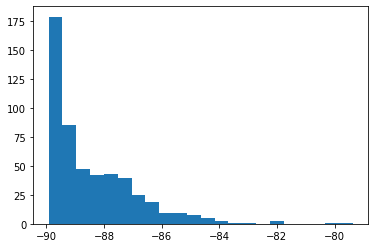

In [11]:
plt.hist(data_reg[:,0:1:sensors_num], bins='auto')

In [22]:
np.max(data_reg[:, :17])

-56.8745

In [7]:
max_v = -float('inf')
min_v = float('inf')
for sample_idx in range(data_reg.shape[0]):
    pu_n = int(data_reg[sample_idx][0])
    max_v = max(max_v, max(data_reg[sample_idx][3:pu_n*3+1:3]))
    min_v = min(min_v, min(data_reg[sample_idx][3:pu_n*3+1:3]))
    

In [12]:
if not sensors:
    noise_floor = 0
if sensors:
    max_v = -85

In [13]:
# Saving images once to save time
# run this cell just for creating images
def creating_image(data_reg, start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=max_v if sensors else max_v)
        if style == "image_intensity":
            if number_image_channels != 3:
                image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                               dtype=float_memory_used), axis=0)
            image_save = np.swapaxes(image, 0, 2)
            plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
        elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
    #         np.save(image_dir + '/image' + str(image_num), image)
            np.savez_compressed(image_dir + '/image' + str(image_num), a=image)
        del image
        

In [12]:
print(data_reg[-2])

[-84.61222 -80.16843 -86.55651 -88.96914 -79.58933 -76.66294 -75.69202
 -74.12955 -71.41905 -89.91388 -62.81991 -90.1087  -89.90674 -81.48449
 -87.72848 -84.58716 -87.32878   1.        6.        6.       47.     ]


In [14]:
def job_creating_images(data):
    jobs = []
    proc_sizes = [data.shape[0]//number_of_proccessors] * (number_of_proccessors)
    proc_sizes[-1] += data.shape[0]%number_of_proccessors
    proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

    for i in range(number_of_proccessors):
        p = Process(target=creating_image, args=(data, proc_idx[i][0], proc_idx[i][1]))
        jobs.append(p)
        p.start()
    for i in range(number_of_proccessors):
        jobs[i].join()

    for i in range(number_of_proccessors):
        jobs[i].terminate()
        jobs[i].close()
    del jobs

In [15]:
job_creating_images(data=data_reg)

100%|██████████| 103/103 [00:00<00:00, 189.69it/s]

100%|██████████| 107/107 [00:00<00:00, 189.68it/s]


In [ ]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point)

In [ ]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point,"close") if math.sqrt((point.x-917)**2+(point.y-415)**2)<=1.5 else None

In [ ]:
count = [0, 0, 0, 0]
idxx = [[],[],[],[]]
for i in range(data_reg.shape[0]):
    pus_c = int(data_reg[i][0]) * 3 + 1
    idx = int(data_reg[i][pus_c]) - 1
    count[idx] += 1
    idxx[idx].append(i)

In [ ]:
print(count)
print(idxx[3])

In [15]:
imm = read_image(0)

In [42]:
sensor_selected_idx

[16, 7, 0, 15, 2, 12, 1, 9, 14, 6, 13, 4, 11, 10, 3, 5, 8]

In [19]:
np.max(imm[0][0])

5.31

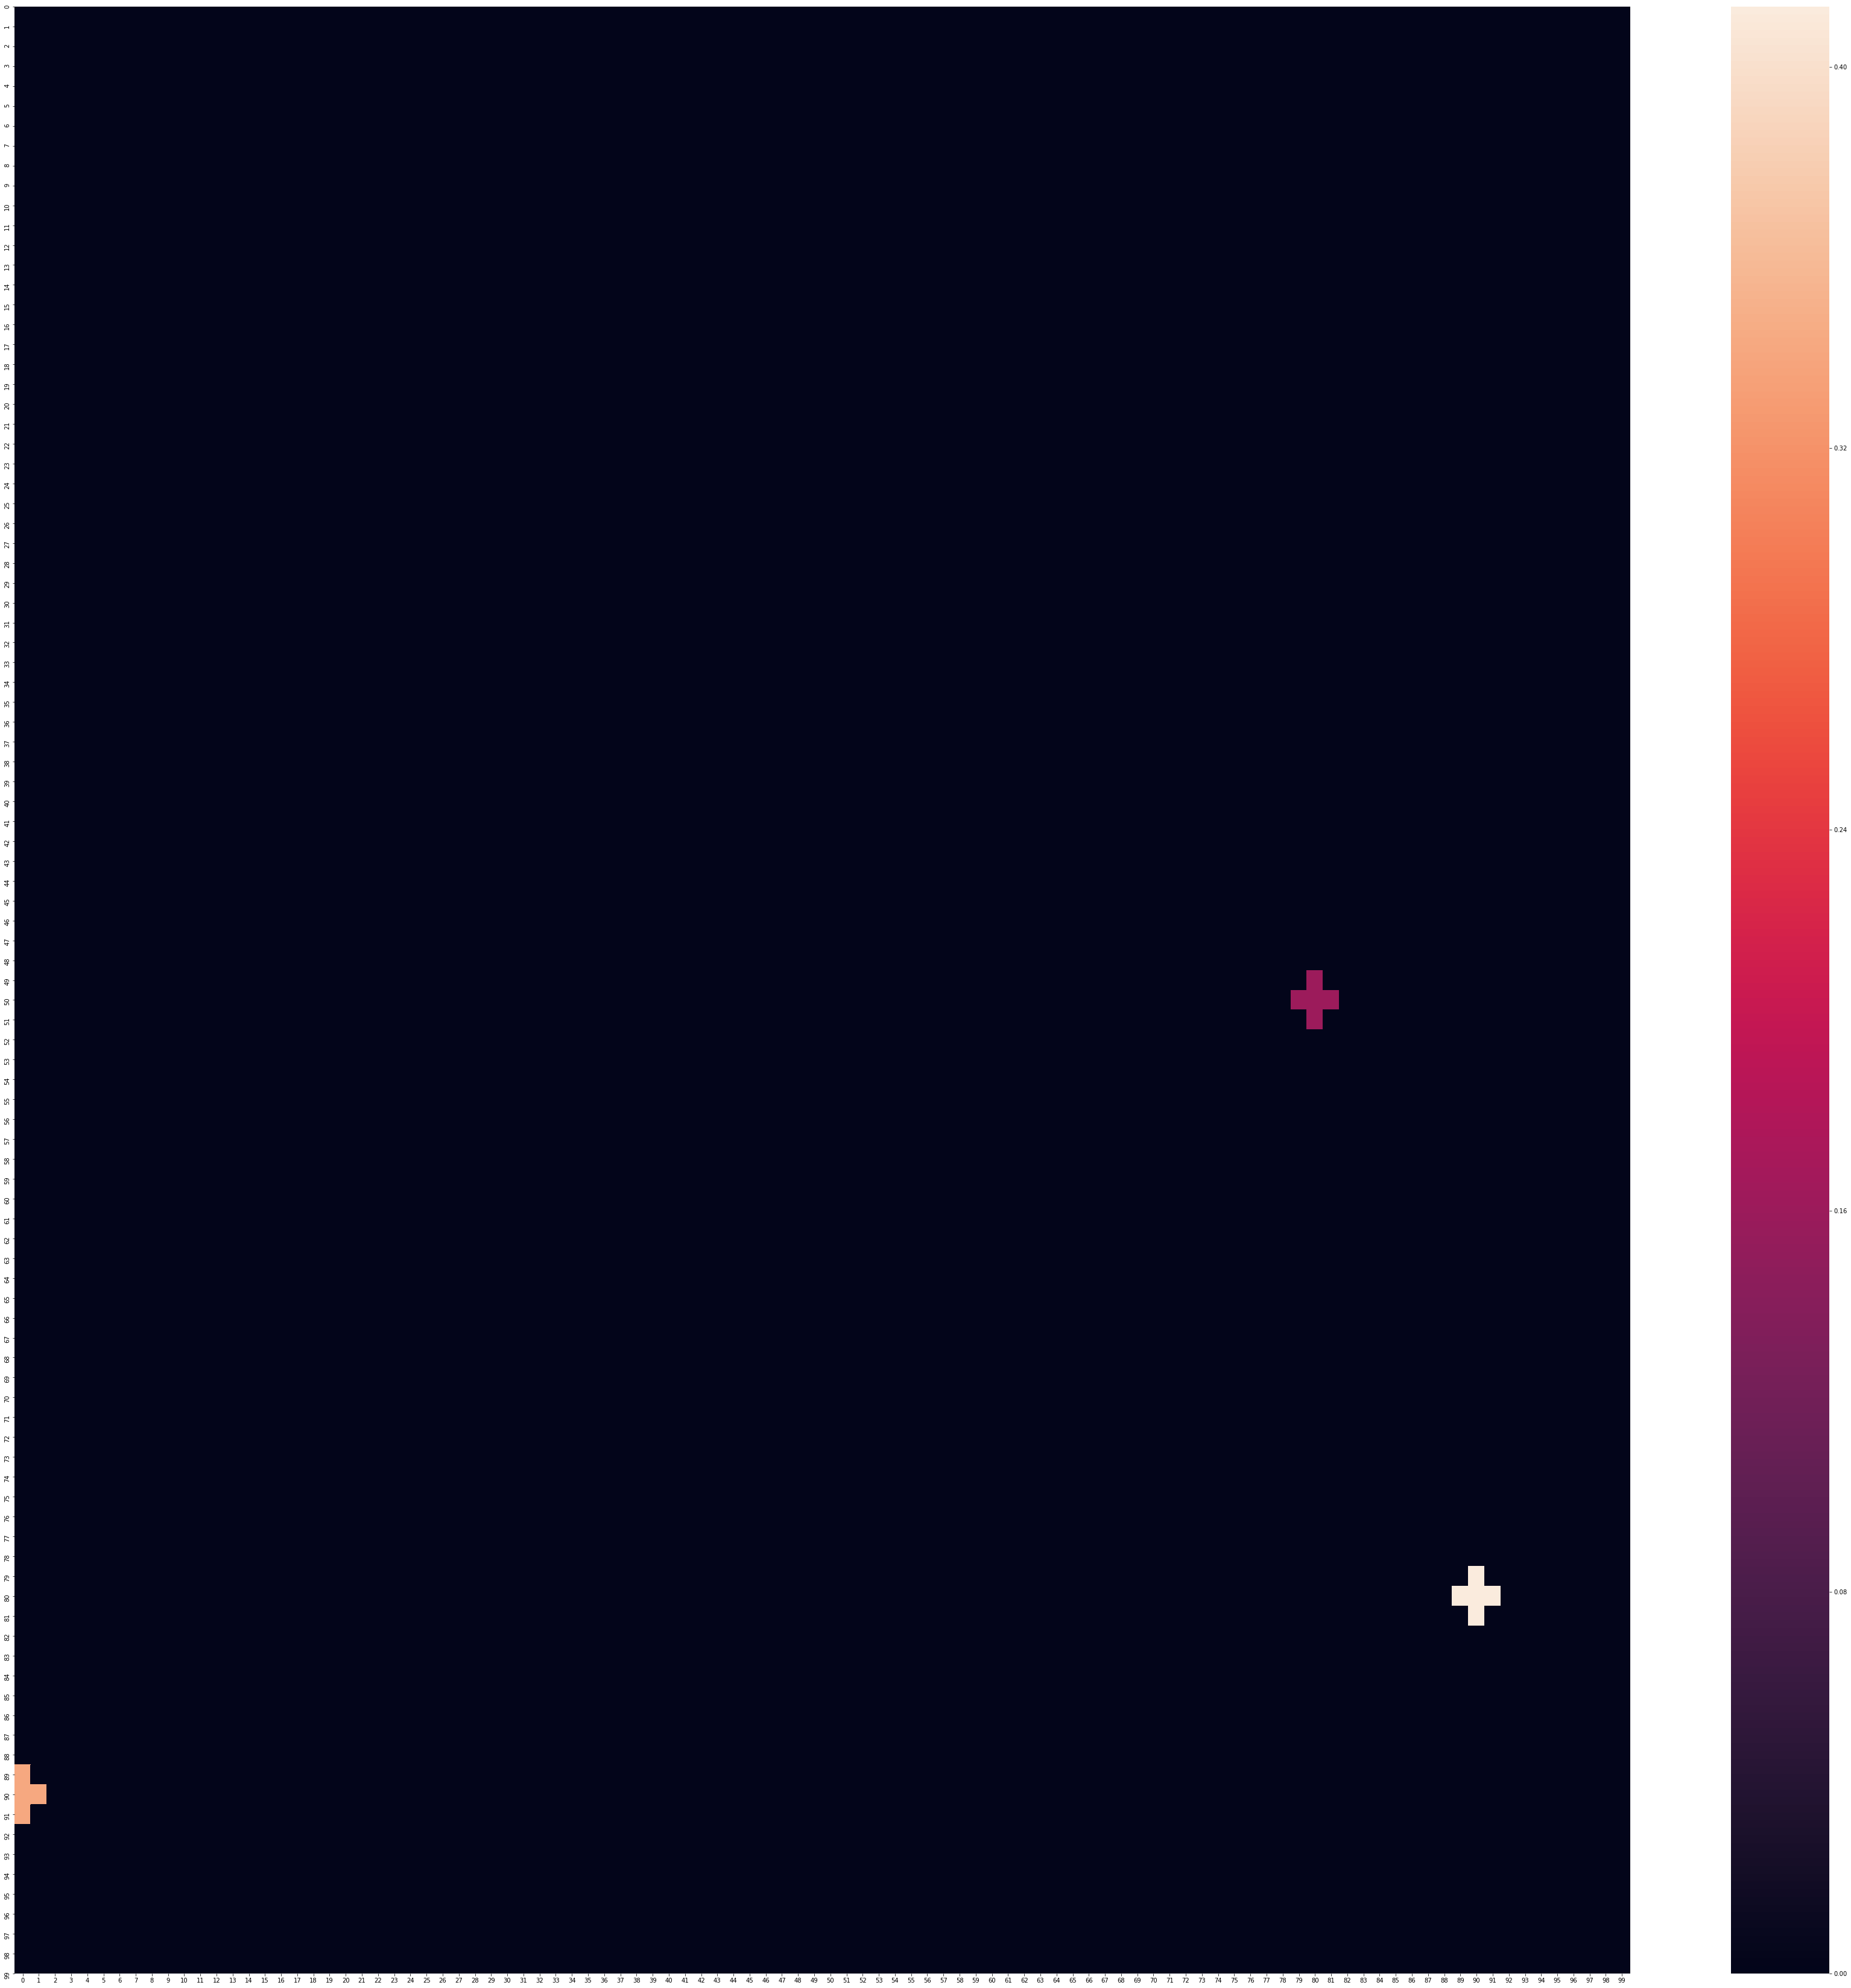

In [21]:
fig, ax = plt.subplots(figsize=(60,60))         # Sample figsize in inches
sns.heatmap(imm[0][5], ax=ax)

In [16]:
def cnn_model(num_filters, kernel_lam, bias_lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"
    convolution_filter, dense_filter = 'selu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (3, 3), (2,2)
    cnn = models.Sequential()
    cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(2*num_filters, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
# from here for 1000
    if max(max_x, max_y) == 1000:
        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))

        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))

        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
    cnn.add(BatchNormalization())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization())
    cnn.add(layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init))
    return cnn


class DataBatchGenerator(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int,
                 number_image_channels:int,
                 max_x, max_y, float_memory_used, conserve=0):
#         print(dataset.shape[0])
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.conserve = conserve
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(np.int)
    
    def __getitem__(self, idx):
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.number_image_channels, self.max_x, self.max_y), dtype=self.float_memory_used)
        batch_y = np.empty((size), dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i)
            batch_y[i] = self.dataset[idx * self.batch_size + i][- 1 - self.conserve]
        return batch_x, batch_y
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)
         

In [17]:
cnn = cnn_model(10, 0, 0)

In [18]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 100, 100)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 50, 50)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 50, 50)        40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 50, 50)        1820      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 25, 25)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 25, 25)        80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 25, 25)        5

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
data_reg.shape

(519, 21)

In [21]:
number_samples = [519]

In [17]:
data_reg = data_reg_bak

In [22]:
#K-Fold cross-validation
import shutil
dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (intensity_degradation + '_' + str(slope))) + (
    "/" + str(sensors_num) + "sensors" if sensors else "/pus") + "/images"
TEST, CONSERVE = True, False
mini_batch = 16 if max(max_x, max_y) == 1000 else 64
epochs = 35 if max(max_x, max_y) == 1000 else 500
MAX_QUEUE_SIZE, WORKERS = 6, 1
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_mae", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0.01, 0.1, 1]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
all_cnns = []
all_diff_power, all_fp_diff_power, all_diff_power_conserve, all_fp_diff_conserve = [], [], [], []

data_reg_bak = data_reg

for number_sample in number_samples: 
    data_reg = data_reg_bak
    np.random.shuffle(data_reg)
    data_reg = data_reg[:number_sample,:]
    num_sample_bucket = data_reg.shape[0]//K_SIZE
    k_samples = [num_sample_bucket] * K_SIZE
    for i in range(data_reg.shape[0]%K_SIZE):
        k_samples[i] += 1
    k_samples = [0] + list(np.cumsum(k_samples))
    print('number_samples:', number_sample)
    all_cnns_k, best_lambda_k = [], []
    diff_power_k, fp_diff_power_k, power_conserve_k, fp_power_conserve_k = [], [], [], []
    data_reg_bak_k = data_reg
    for k in range(K_SIZE):
        data_reg = data_reg_bak_k
        k_low_idx, k_high_idx = k_samples[k], k_samples[k+1] #inclusive, exclusive
        data_k_test = data_reg[k_low_idx:k_high_idx, :]
        if k == 0:
            data_k_train = data_reg[k_high_idx:, :]
        elif k == K_SIZE - 1:
            data_k_train = data_reg[:k_low_idx, :]
        else:
            data_k_train = np.concatenate((data_reg[:k_low_idx, :], data_reg[k_high_idx:]))
        np.random.shuffle(data_k_train)
        data_reg = np.concatenate((data_k_train, data_k_test))
        
        #prepare to create images
        if os.path.exists(image_dir):
            shutil.rmtree(image_dir)
        os.makedirs(image_dir)

        # creating images
        job_creating_images(data=data_reg)
        
        #create folder for 
        MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + str(number_sample) + "/fold_" + str(k)
        if not os.path.exists(MODEL_PATH):
            os.makedirs(MODEL_PATH)
        MODEL_PATH += "/best_model_lambda_"
        
        number_start = time.time()
        
        #creating models
        cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer='adam', metrics=['mse', 'mae', fp_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb_idx)+ '.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb_idx in range(len(lambda_vec))]
        
        # training
        test_k_size = data_k_test.shape[0]
        val_k_size = math.ceil((data_reg.shape[0] - test_k_size) * validation_size)
        train_k_size  = data_reg.shape[0] - val_k_size - test_k_size
        train_generator = DataBatchGenerator(dataset=data_reg[:train_k_size], batch_size=mini_batch,
                                             start_idx=0, number_image_channels=number_image_channels,
                                             max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    
        val_generator = DataBatchGenerator(dataset=data_reg[train_k_size:train_k_size + val_k_size], 
                                           batch_size=mini_batch,
                                           start_idx=train_k_size,
                                           number_image_channels=number_image_channels,
                                           max_x=max_x, max_y=max_y, 
                                           float_memory_used=float_memory_used)
        
        
        print("#Fold:", k, ", Training Size:", train_k_size, ", Validation size:", val_k_size,
              ", Test Size", test_k_size)
        
        for lamb_idx, lamb in enumerate(lambda_vec):
            lambda_start = time.time()
            cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=0,
                               validation_data=val_generator, 
                               shuffle=False, callbacks=[checkpointers[lamb_idx]], 
                               workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                               use_multiprocessing=False)

            print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
            print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
                  [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
            print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
                  [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
            print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
                  [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
            print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
                  [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
        
        # find the best lambda
        models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                          lam_idx,_ in enumerate(lambda_vec)]
        best_lamb_idx = models_min_mae.index(min(models_min_mae))
        best_lambda_k.append(lambda_vec[best_lamb_idx])
        print("\n#Fold:", k, "\nTrainig set size:", train_k_size, 
              ", Time:", str(datetime.timedelta(seconds=int(time.time() - number_start))),
              ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" ,
              ("fp_" if hyper_metric == "val_fp_mae" else ""),
              ", error:", round(min(models_min_mae), 3))
        all_cnns_k.append(cnns)
        del cnns, train_generator, val_generator, checkpointers
        
        #evaluating
        if TEST:
            # evaluating test images
            best_model = None
            best_model = models.load_model(MODEL_PATH + str(best_lamb_idx) + '.h5', 
                                           custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                           'fp_mae': fp_mae,
                                                          'mae':'mae', 'mse':'mse'})
            test_generator = DataBatchGenerator(dataset=data_reg[train_k_size + val_k_size:], 
                                                batch_size=mini_batch,
                                                start_idx=train_k_size + val_k_size, 
                                                number_image_channels=number_image_channels,
                                                max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

            print("Test starts: ", train_k_size + val_k_size, ", ends: ", data_reg.shape[0] - 1)
            time.sleep(1)
            test_res = best_model.evaluate(test_generator, verbose=1, 
                                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)

            test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                             for mtrc in ['mae','fp_mae']]
            test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
            diff_power_k.append(round(test_mae, 3))
            fp_diff_power_k.append(round(test_fp_mae, 3))
            print('average_error: ', diff_power_k[-1], ', fp_average_error: ', 
                  fp_diff_power_k[-1])
            del best_model, test_generator
    all_diff_power.append(diff_power_k)
    all_fp_diff_power.append(fp_diff_power_k)
    average_diff_power.append(sum(diff_power_k)/len(diff_power_k))
    fp_mean_power.append(sum(fp_diff_power_k)/len(fp_diff_power_k))
    print("Number Sample:", number_sample, ", Average Error:", average_diff_power[-1], 
          "FP Average Error:", fp_mean_power[-1])
    if CONSERVE:
        all_diff_power_conserve.append(power_conserve_k)
        all_fp_diff_conserve.append(fp_power_conserve_k)
        average_diff_power_conserve.append(sum(power_conserve_k)/len(power_conserve_k))
        fp_mean_power_conserve.append(sum(power_conserve_k)/len(power_conserve_k))
    
    
    var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
    pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
                 dataset_name, average_diff_power_conserve, fp_mean_power_conserve, all_diff_power, 
                 all_fp_diff_power, all_diff_power_conserve, all_fp_diff_conserve],
                 file=var_f)
    var_f.close()   

number_samples: 519


100%|██████████| 103/103 [00:00<00:00, 193.31it/s]

100%|██████████| 107/107 [00:00<00:00, 188.94it/s]


#Fold: 0 , Training Size: 420 , Validation size: 47 , Test Size 52

Epoch 00001: val_mae improved from inf to 49.15274, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 49.15274 to 48.97751, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_0.h5

Epoch 00003: val_mae improved from 48.97751 to 48.78480, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 48.78480 to 48.58834, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 48.58834 to 48.37000, saving model to 


Epoch 00045: val_mae improved from 24.21064 to 23.26195, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_0.h5

Epoch 00046: val_mae did not improve from 23.26195

Epoch 00047: val_mae improved from 23.26195 to 20.00248, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_0.h5

Epoch 00048: val_mae improved from 20.00248 to 18.08249, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_0.h5

Epoch 00049: val_mae did not improve from 18.08249

Epoch 00050: val_mae improved from 18.08249 to 17.53053, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_0.h5

Epoch 00051: val_mae improved f


Epoch 00158: val_mae did not improve from 7.19985

Epoch 00159: val_mae did not improve from 7.19985

Epoch 00160: val_mae did not improve from 7.19985

Epoch 00161: val_mae did not improve from 7.19985

Epoch 00162: val_mae did not improve from 7.19985

Epoch 00163: val_mae did not improve from 7.19985

Epoch 00164: val_mae did not improve from 7.19985

Epoch 00165: val_mae did not improve from 7.19985

Epoch 00166: val_mae did not improve from 7.19985

Epoch 00167: val_mae did not improve from 7.19985

Epoch 00168: val_mae did not improve from 7.19985

Epoch 00169: val_mae did not improve from 7.19985

Epoch 00170: val_mae did not improve from 7.19985

Epoch 00171: val_mae did not improve from 7.19985

Epoch 00172: val_mae did not improve from 7.19985

Epoch 00173: val_mae did not improve from 7.19985

Epoch 00174: val_mae did not improve from 7.19985

Epoch 00175: val_mae did not improve from 7.19985

Epoch 00176: val_mae did not improve from 7.19985

Epoch 00177: val_mae did not i


Epoch 00319: val_mae did not improve from 7.19985

Epoch 00320: val_mae did not improve from 7.19985

Epoch 00321: val_mae did not improve from 7.19985

Epoch 00322: val_mae did not improve from 7.19985

Epoch 00323: val_mae did not improve from 7.19985

Epoch 00324: val_mae did not improve from 7.19985

Epoch 00325: val_mae did not improve from 7.19985

Epoch 00326: val_mae did not improve from 7.19985

Epoch 00327: val_mae did not improve from 7.19985

Epoch 00328: val_mae did not improve from 7.19985

Epoch 00329: val_mae did not improve from 7.19985

Epoch 00330: val_mae did not improve from 7.19985

Epoch 00331: val_mae did not improve from 7.19985

Epoch 00332: val_mae did not improve from 7.19985

Epoch 00333: val_mae did not improve from 7.19985

Epoch 00334: val_mae did not improve from 7.19985

Epoch 00335: val_mae did not improve from 7.19985

Epoch 00336: val_mae did not improve from 7.19985

Epoch 00337: val_mae did not improve from 7.19985

Epoch 00338: val_mae did not i


Epoch 00480: val_mae did not improve from 7.19985

Epoch 00481: val_mae did not improve from 7.19985

Epoch 00482: val_mae did not improve from 7.19985

Epoch 00483: val_mae did not improve from 7.19985

Epoch 00484: val_mae did not improve from 7.19985

Epoch 00485: val_mae did not improve from 7.19985

Epoch 00486: val_mae did not improve from 7.19985

Epoch 00487: val_mae did not improve from 7.19985

Epoch 00488: val_mae did not improve from 7.19985

Epoch 00489: val_mae did not improve from 7.19985

Epoch 00490: val_mae did not improve from 7.19985

Epoch 00491: val_mae did not improve from 7.19985

Epoch 00492: val_mae did not improve from 7.19985

Epoch 00493: val_mae did not improve from 7.19985

Epoch 00494: val_mae did not improve from 7.19985

Epoch 00495: val_mae did not improve from 7.19985

Epoch 00496: val_mae did not improve from 7.19985

Epoch 00497: val_mae did not improve from 7.19985

Epoch 00498: val_mae did not improve from 7.19985

Epoch 00499: val_mae did not i


Epoch 00001: val_mae improved from inf to 49.23119, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_1.h5

Epoch 00002: val_mae improved from 49.23119 to 49.16546, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_1.h5

Epoch 00003: val_mae improved from 49.16546 to 49.06392, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_1.h5

Epoch 00004: val_mae improved from 49.06392 to 48.93443, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_1.h5

Epoch 00005: val_mae improved from 48.93443 to 48.78117, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00042: val_mae improved from 24.98916 to 22.41893, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_1.h5

Epoch 00043: val_mae improved from 22.41893 to 19.60419, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_1.h5

Epoch 00044: val_mae improved from 19.60419 to 18.11613, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_1.h5

Epoch 00045: val_mae improved from 18.11613 to 15.21626, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_1.h5

Epoch 00046: val_mae improved from 15.21626 to 14.52565, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_po


Epoch 00154: val_mae did not improve from 8.99336

Epoch 00155: val_mae did not improve from 8.99336

Epoch 00156: val_mae did not improve from 8.99336

Epoch 00157: val_mae did not improve from 8.99336

Epoch 00158: val_mae did not improve from 8.99336

Epoch 00159: val_mae did not improve from 8.99336

Epoch 00160: val_mae did not improve from 8.99336

Epoch 00161: val_mae did not improve from 8.99336

Epoch 00162: val_mae did not improve from 8.99336

Epoch 00163: val_mae did not improve from 8.99336

Epoch 00164: val_mae did not improve from 8.99336

Epoch 00165: val_mae did not improve from 8.99336

Epoch 00166: val_mae did not improve from 8.99336

Epoch 00167: val_mae did not improve from 8.99336

Epoch 00168: val_mae did not improve from 8.99336

Epoch 00169: val_mae did not improve from 8.99336

Epoch 00170: val_mae did not improve from 8.99336

Epoch 00171: val_mae did not improve from 8.99336

Epoch 00172: val_mae did not improve from 8.99336

Epoch 00173: val_mae did not i


Epoch 00315: val_mae did not improve from 8.99336

Epoch 00316: val_mae did not improve from 8.99336

Epoch 00317: val_mae did not improve from 8.99336

Epoch 00318: val_mae did not improve from 8.99336

Epoch 00319: val_mae did not improve from 8.99336

Epoch 00320: val_mae did not improve from 8.99336

Epoch 00321: val_mae did not improve from 8.99336

Epoch 00322: val_mae did not improve from 8.99336

Epoch 00323: val_mae did not improve from 8.99336

Epoch 00324: val_mae did not improve from 8.99336

Epoch 00325: val_mae did not improve from 8.99336

Epoch 00326: val_mae did not improve from 8.99336

Epoch 00327: val_mae did not improve from 8.99336

Epoch 00328: val_mae did not improve from 8.99336

Epoch 00329: val_mae did not improve from 8.99336

Epoch 00330: val_mae did not improve from 8.99336

Epoch 00331: val_mae did not improve from 8.99336

Epoch 00332: val_mae did not improve from 8.99336

Epoch 00333: val_mae did not improve from 8.99336

Epoch 00334: val_mae did not i


Epoch 00470: val_mae did not improve from 8.88445

Epoch 00471: val_mae did not improve from 8.88445

Epoch 00472: val_mae did not improve from 8.88445

Epoch 00473: val_mae did not improve from 8.88445

Epoch 00474: val_mae did not improve from 8.88445

Epoch 00475: val_mae did not improve from 8.88445

Epoch 00476: val_mae did not improve from 8.88445

Epoch 00477: val_mae did not improve from 8.88445

Epoch 00478: val_mae did not improve from 8.88445

Epoch 00479: val_mae did not improve from 8.88445

Epoch 00480: val_mae did not improve from 8.88445

Epoch 00481: val_mae did not improve from 8.88445

Epoch 00482: val_mae did not improve from 8.88445

Epoch 00483: val_mae did not improve from 8.88445

Epoch 00484: val_mae did not improve from 8.88445

Epoch 00485: val_mae did not improve from 8.88445

Epoch 00486: val_mae did not improve from 8.88445

Epoch 00487: val_mae did not improve from 8.88445

Epoch 00488: val_mae did not improve from 8.88445

Epoch 00489: val_mae did not i


Epoch 00001: val_mae improved from inf to 49.17677, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_2.h5

Epoch 00002: val_mae improved from 49.17677 to 49.06927, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_2.h5

Epoch 00003: val_mae improved from 49.06927 to 48.98330, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_2.h5

Epoch 00004: val_mae improved from 48.98330 to 48.89344, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_2.h5

Epoch 00005: val_mae improved from 48.89344 to 48.82903, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00040: val_mae did not improve from 17.03073

Epoch 00041: val_mae improved from 17.03073 to 15.87056, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_2.h5

Epoch 00042: val_mae improved from 15.87056 to 13.63327, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_2.h5

Epoch 00043: val_mae improved from 13.63327 to 13.60737, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_2.h5

Epoch 00044: val_mae did not improve from 13.60737

Epoch 00045: val_mae improved from 13.60737 to 10.59635, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_0/best_model_lambda_2.h5

Epoch 00046: val_mae improved f


Epoch 00166: val_mae did not improve from 7.68549

Epoch 00167: val_mae did not improve from 7.68549

Epoch 00168: val_mae did not improve from 7.68549

Epoch 00169: val_mae did not improve from 7.68549

Epoch 00170: val_mae did not improve from 7.68549

Epoch 00171: val_mae did not improve from 7.68549

Epoch 00172: val_mae did not improve from 7.68549

Epoch 00173: val_mae did not improve from 7.68549

Epoch 00174: val_mae did not improve from 7.68549

Epoch 00175: val_mae did not improve from 7.68549

Epoch 00176: val_mae did not improve from 7.68549

Epoch 00177: val_mae did not improve from 7.68549

Epoch 00178: val_mae did not improve from 7.68549

Epoch 00179: val_mae did not improve from 7.68549

Epoch 00180: val_mae did not improve from 7.68549

Epoch 00181: val_mae did not improve from 7.68549

Epoch 00182: val_mae did not improve from 7.68549

Epoch 00183: val_mae did not improve from 7.68549

Epoch 00184: val_mae did not improve from 7.68549

Epoch 00185: val_mae did not i


Epoch 00318: val_mae did not improve from 7.29201

Epoch 00319: val_mae did not improve from 7.29201

Epoch 00320: val_mae did not improve from 7.29201

Epoch 00321: val_mae did not improve from 7.29201

Epoch 00322: val_mae did not improve from 7.29201

Epoch 00323: val_mae did not improve from 7.29201

Epoch 00324: val_mae did not improve from 7.29201

Epoch 00325: val_mae did not improve from 7.29201

Epoch 00326: val_mae did not improve from 7.29201

Epoch 00327: val_mae did not improve from 7.29201

Epoch 00328: val_mae did not improve from 7.29201

Epoch 00329: val_mae did not improve from 7.29201

Epoch 00330: val_mae did not improve from 7.29201

Epoch 00331: val_mae did not improve from 7.29201

Epoch 00332: val_mae did not improve from 7.29201

Epoch 00333: val_mae did not improve from 7.29201

Epoch 00334: val_mae did not improve from 7.29201

Epoch 00335: val_mae did not improve from 7.29201

Epoch 00336: val_mae did not improve from 7.29201

Epoch 00337: val_mae did not i


Epoch 00476: val_mae did not improve from 7.25207

Epoch 00477: val_mae did not improve from 7.25207

Epoch 00478: val_mae did not improve from 7.25207

Epoch 00479: val_mae did not improve from 7.25207

Epoch 00480: val_mae did not improve from 7.25207

Epoch 00481: val_mae did not improve from 7.25207

Epoch 00482: val_mae did not improve from 7.25207

Epoch 00483: val_mae did not improve from 7.25207

Epoch 00484: val_mae did not improve from 7.25207

Epoch 00485: val_mae did not improve from 7.25207

Epoch 00486: val_mae did not improve from 7.25207

Epoch 00487: val_mae did not improve from 7.25207

Epoch 00488: val_mae did not improve from 7.25207

Epoch 00489: val_mae did not improve from 7.25207

Epoch 00490: val_mae did not improve from 7.25207

Epoch 00491: val_mae did not improve from 7.25207

Epoch 00492: val_mae did not improve from 7.25207

Epoch 00493: val_mae did not improve from 7.25207

Epoch 00494: val_mae did not improve from 7.25207

Epoch 00495: val_mae did not i

Test starts:  467 , ends:  518
1/1 [==============================] - 0s 770us/step - loss: 151.8357 - mse: 149.3341 - mae: 6.6927 - fp_mae: 1.2793
average_error:  6.693 , fp_average_error:  1.279


100%|██████████| 107/107 [00:00<00:00, 231.98it/s]


#Fold: 1 , Training Size: 420 , Validation size: 47 , Test Size 52

Epoch 00001: val_mae improved from inf to 49.73377, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 49.73377 to 49.63641, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_0.h5

Epoch 00003: val_mae improved from 49.63641 to 49.52221, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 49.52221 to 49.39983, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 49.39983 to 49.25079, saving model to 


Epoch 00040: val_mae improved from 26.61804 to 26.02738, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_0.h5

Epoch 00041: val_mae improved from 26.02738 to 24.86233, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_0.h5

Epoch 00042: val_mae improved from 24.86233 to 24.07270, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_0.h5

Epoch 00043: val_mae improved from 24.07270 to 23.03477, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_0.h5

Epoch 00044: val_mae improved from 23.03477 to 22.48559, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_po


Epoch 00105: val_mae did not improve from 5.90618

Epoch 00106: val_mae did not improve from 5.90618

Epoch 00107: val_mae improved from 5.90618 to 5.90298, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_0.h5

Epoch 00108: val_mae did not improve from 5.90298

Epoch 00109: val_mae did not improve from 5.90298

Epoch 00110: val_mae did not improve from 5.90298

Epoch 00111: val_mae did not improve from 5.90298

Epoch 00112: val_mae did not improve from 5.90298

Epoch 00113: val_mae did not improve from 5.90298

Epoch 00114: val_mae did not improve from 5.90298

Epoch 00115: val_mae did not improve from 5.90298

Epoch 00116: val_mae did not improve from 5.90298

Epoch 00117: val_mae did not improve from 5.90298

Epoch 00118: val_mae did not improve from 5.90298

Epoch 00119: val_mae did not improve from 5.90298

Epoch 00120: val_mae did not improve from 5.90298

Epoch 00121: val_mae


Epoch 00260: val_mae did not improve from 5.87989

Epoch 00261: val_mae did not improve from 5.87989

Epoch 00262: val_mae did not improve from 5.87989

Epoch 00263: val_mae did not improve from 5.87989

Epoch 00264: val_mae did not improve from 5.87989

Epoch 00265: val_mae did not improve from 5.87989

Epoch 00266: val_mae did not improve from 5.87989

Epoch 00267: val_mae did not improve from 5.87989

Epoch 00268: val_mae did not improve from 5.87989

Epoch 00269: val_mae did not improve from 5.87989

Epoch 00270: val_mae did not improve from 5.87989

Epoch 00271: val_mae did not improve from 5.87989

Epoch 00272: val_mae did not improve from 5.87989

Epoch 00273: val_mae did not improve from 5.87989

Epoch 00274: val_mae did not improve from 5.87989

Epoch 00275: val_mae did not improve from 5.87989

Epoch 00276: val_mae did not improve from 5.87989

Epoch 00277: val_mae did not improve from 5.87989

Epoch 00278: val_mae did not improve from 5.87989

Epoch 00279: val_mae did not i


Epoch 00421: val_mae did not improve from 5.87989

Epoch 00422: val_mae did not improve from 5.87989

Epoch 00423: val_mae did not improve from 5.87989

Epoch 00424: val_mae did not improve from 5.87989

Epoch 00425: val_mae did not improve from 5.87989

Epoch 00426: val_mae did not improve from 5.87989

Epoch 00427: val_mae did not improve from 5.87989

Epoch 00428: val_mae did not improve from 5.87989

Epoch 00429: val_mae did not improve from 5.87989

Epoch 00430: val_mae did not improve from 5.87989

Epoch 00431: val_mae did not improve from 5.87989

Epoch 00432: val_mae did not improve from 5.87989

Epoch 00433: val_mae did not improve from 5.87989

Epoch 00434: val_mae did not improve from 5.87989

Epoch 00435: val_mae did not improve from 5.87989

Epoch 00436: val_mae did not improve from 5.87989

Epoch 00437: val_mae did not improve from 5.87989

Epoch 00438: val_mae did not improve from 5.87989

Epoch 00439: val_mae did not improve from 5.87989

Epoch 00440: val_mae did not i


Epoch 00001: val_mae improved from inf to 49.70045, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_1.h5

Epoch 00002: val_mae improved from 49.70045 to 49.61170, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_1.h5

Epoch 00003: val_mae improved from 49.61170 to 49.52858, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_1.h5

Epoch 00004: val_mae improved from 49.52858 to 49.44988, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_1.h5

Epoch 00005: val_mae improved from 49.44988 to 49.36835, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00042: val_mae improved from 34.42739 to 33.68752, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_1.h5

Epoch 00043: val_mae improved from 33.68752 to 33.22937, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_1.h5

Epoch 00044: val_mae improved from 33.22937 to 32.92038, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_1.h5

Epoch 00045: val_mae improved from 32.92038 to 32.35871, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_1.h5

Epoch 00046: val_mae improved from 32.35871 to 31.46166, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_po


Epoch 00119: val_mae did not improve from 6.97745

Epoch 00120: val_mae did not improve from 6.97745

Epoch 00121: val_mae did not improve from 6.97745

Epoch 00122: val_mae did not improve from 6.97745

Epoch 00123: val_mae did not improve from 6.97745

Epoch 00124: val_mae did not improve from 6.97745

Epoch 00125: val_mae did not improve from 6.97745

Epoch 00126: val_mae did not improve from 6.97745

Epoch 00127: val_mae did not improve from 6.97745

Epoch 00128: val_mae did not improve from 6.97745

Epoch 00129: val_mae did not improve from 6.97745

Epoch 00130: val_mae did not improve from 6.97745

Epoch 00131: val_mae did not improve from 6.97745

Epoch 00132: val_mae did not improve from 6.97745

Epoch 00133: val_mae did not improve from 6.97745

Epoch 00134: val_mae did not improve from 6.97745

Epoch 00135: val_mae did not improve from 6.97745

Epoch 00136: val_mae did not improve from 6.97745

Epoch 00137: val_mae did not improve from 6.97745

Epoch 00138: val_mae did not i


Epoch 00267: val_mae did not improve from 6.27395

Epoch 00268: val_mae did not improve from 6.27395

Epoch 00269: val_mae did not improve from 6.27395

Epoch 00270: val_mae did not improve from 6.27395

Epoch 00271: val_mae improved from 6.27395 to 6.25620, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_1.h5

Epoch 00272: val_mae improved from 6.25620 to 6.25230, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_1.h5

Epoch 00273: val_mae did not improve from 6.25230

Epoch 00274: val_mae improved from 6.25230 to 6.01453, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_1.h5

Epoch 00275: val_mae did not improve from 6.01453

Epoch 00276: val_mae did not improve from 6.01453




Epoch 00412: val_mae did not improve from 5.69504

Epoch 00413: val_mae did not improve from 5.69504

Epoch 00414: val_mae did not improve from 5.69504

Epoch 00415: val_mae did not improve from 5.69504

Epoch 00416: val_mae did not improve from 5.69504

Epoch 00417: val_mae did not improve from 5.69504

Epoch 00418: val_mae did not improve from 5.69504

Epoch 00419: val_mae did not improve from 5.69504

Epoch 00420: val_mae did not improve from 5.69504

Epoch 00421: val_mae did not improve from 5.69504

Epoch 00422: val_mae did not improve from 5.69504

Epoch 00423: val_mae did not improve from 5.69504

Epoch 00424: val_mae did not improve from 5.69504

Epoch 00425: val_mae did not improve from 5.69504

Epoch 00426: val_mae did not improve from 5.69504

Epoch 00427: val_mae did not improve from 5.69504

Epoch 00428: val_mae did not improve from 5.69504

Epoch 00429: val_mae did not improve from 5.69504

Epoch 00430: val_mae did not improve from 5.69504

Epoch 00431: val_mae did not i


Epoch 00001: val_mae improved from inf to 49.71437, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_2.h5

Epoch 00002: val_mae improved from 49.71437 to 49.68753, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_2.h5

Epoch 00003: val_mae improved from 49.68753 to 49.67092, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_2.h5

Epoch 00004: val_mae improved from 49.67092 to 49.63468, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_2.h5

Epoch 00005: val_mae improved from 49.63468 to 49.55863, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00040: val_mae improved from 13.23171 to 10.40445, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_2.h5

Epoch 00041: val_mae improved from 10.40445 to 10.38040, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_2.h5

Epoch 00042: val_mae did not improve from 10.38040

Epoch 00043: val_mae improved from 10.38040 to 7.16699, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_1/best_model_lambda_2.h5

Epoch 00044: val_mae did not improve from 7.16699

Epoch 00045: val_mae did not improve from 7.16699

Epoch 00046: val_mae did not improve from 7.16699

Epoch 00047: val_mae did not improve from 7.16699

Epoch 00048: val_mae did not improve from 7.16699

Epoch 00049: val_mae did not improve from 7.1


Epoch 00172: val_mae did not improve from 5.35716

Epoch 00173: val_mae did not improve from 5.35716

Epoch 00174: val_mae did not improve from 5.35716

Epoch 00175: val_mae did not improve from 5.35716

Epoch 00176: val_mae did not improve from 5.35716

Epoch 00177: val_mae did not improve from 5.35716

Epoch 00178: val_mae did not improve from 5.35716

Epoch 00179: val_mae did not improve from 5.35716

Epoch 00180: val_mae did not improve from 5.35716

Epoch 00181: val_mae did not improve from 5.35716

Epoch 00182: val_mae did not improve from 5.35716

Epoch 00183: val_mae did not improve from 5.35716

Epoch 00184: val_mae did not improve from 5.35716

Epoch 00185: val_mae did not improve from 5.35716

Epoch 00186: val_mae did not improve from 5.35716

Epoch 00187: val_mae did not improve from 5.35716

Epoch 00188: val_mae did not improve from 5.35716

Epoch 00189: val_mae did not improve from 5.35716

Epoch 00190: val_mae did not improve from 5.35716

Epoch 00191: val_mae did not i


Epoch 00333: val_mae did not improve from 5.35716

Epoch 00334: val_mae did not improve from 5.35716

Epoch 00335: val_mae did not improve from 5.35716

Epoch 00336: val_mae did not improve from 5.35716

Epoch 00337: val_mae did not improve from 5.35716

Epoch 00338: val_mae did not improve from 5.35716

Epoch 00339: val_mae did not improve from 5.35716

Epoch 00340: val_mae did not improve from 5.35716

Epoch 00341: val_mae did not improve from 5.35716

Epoch 00342: val_mae did not improve from 5.35716

Epoch 00343: val_mae did not improve from 5.35716

Epoch 00344: val_mae did not improve from 5.35716

Epoch 00345: val_mae did not improve from 5.35716

Epoch 00346: val_mae did not improve from 5.35716

Epoch 00347: val_mae did not improve from 5.35716

Epoch 00348: val_mae did not improve from 5.35716

Epoch 00349: val_mae did not improve from 5.35716

Epoch 00350: val_mae did not improve from 5.35716

Epoch 00351: val_mae did not improve from 5.35716

Epoch 00352: val_mae did not i


Epoch 00494: val_mae did not improve from 5.35716

Epoch 00495: val_mae did not improve from 5.35716

Epoch 00496: val_mae did not improve from 5.35716

Epoch 00497: val_mae did not improve from 5.35716

Epoch 00498: val_mae did not improve from 5.35716

Epoch 00499: val_mae did not improve from 5.35716

Epoch 00500: val_mae did not improve from 5.35716

Lambda: 1 , Time: 0:03:57
Train Error(all epochs): 1.8049590587615967 
 [49.113, 48.967, 48.88, 48.787, 48.677, 48.55, 48.403, 48.225, 48.015, 47.778, 47.506, 47.189, 46.826, 46.42, 45.944, 45.417, 44.838, 44.2, 43.493, 42.724, 41.898, 40.994, 40.055, 39.03, 37.966, 36.845, 35.648, 34.435, 33.15, 31.837, 30.5, 29.141, 27.727, 26.33, 24.948, 23.521, 22.18, 20.804, 19.534, 18.199, 17.132, 15.961, 14.918, 14.019, 13.008, 12.156, 11.458, 10.629, 10.071, 9.398, 8.969, 8.401, 7.984, 7.717, 7.332, 7.063, 6.869, 6.616, 6.528, 6.386, 6.228, 6.212, 5.99, 5.737, 5.568, 5.484, 5.502, 5.245, 5.193, 5.134, 5.142, 5.21, 5.288, 5.4, 5.226, 5.267, 5.2

Test starts:  467 , ends:  518
1/1 [==============================] - 0s 1ms/step - loss: 156.0125 - mse: 85.3174 - mae: 7.0917 - fp_mae: 2.9470
average_error:  7.092 , fp_average_error:  2.947


100%|██████████| 107/107 [00:00<00:00, 245.68it/s]


#Fold: 2 , Training Size: 420 , Validation size: 47 , Test Size 52

Epoch 00001: val_mae improved from inf to 48.59294, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 48.59294 to 48.51162, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_0.h5

Epoch 00003: val_mae improved from 48.51162 to 48.41771, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 48.41771 to 48.34321, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 48.34321 to 48.22878, saving model to 


Epoch 00050: val_mae did not improve from 25.25458

Epoch 00051: val_mae did not improve from 25.25458

Epoch 00052: val_mae did not improve from 25.25458

Epoch 00053: val_mae improved from 25.25458 to 23.96426, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_0.h5

Epoch 00054: val_mae did not improve from 23.96426

Epoch 00055: val_mae improved from 23.96426 to 19.69616, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_0.h5

Epoch 00056: val_mae did not improve from 19.69616

Epoch 00057: val_mae improved from 19.69616 to 19.65331, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_0.h5

Epoch 00058: val_mae did not improve from 19.65331

Epoch 00059: val_mae did not improve fr


Epoch 00133: val_mae did not improve from 6.18546

Epoch 00134: val_mae did not improve from 6.18546

Epoch 00135: val_mae did not improve from 6.18546

Epoch 00136: val_mae did not improve from 6.18546

Epoch 00137: val_mae did not improve from 6.18546

Epoch 00138: val_mae did not improve from 6.18546

Epoch 00139: val_mae did not improve from 6.18546

Epoch 00140: val_mae did not improve from 6.18546

Epoch 00141: val_mae did not improve from 6.18546

Epoch 00142: val_mae did not improve from 6.18546

Epoch 00143: val_mae did not improve from 6.18546

Epoch 00144: val_mae did not improve from 6.18546

Epoch 00145: val_mae did not improve from 6.18546

Epoch 00146: val_mae did not improve from 6.18546

Epoch 00147: val_mae did not improve from 6.18546

Epoch 00148: val_mae did not improve from 6.18546

Epoch 00149: val_mae did not improve from 6.18546

Epoch 00150: val_mae did not improve from 6.18546

Epoch 00151: val_mae did not improve from 6.18546

Epoch 00152: val_mae did not i


Epoch 00294: val_mae did not improve from 6.18546

Epoch 00295: val_mae did not improve from 6.18546

Epoch 00296: val_mae did not improve from 6.18546

Epoch 00297: val_mae did not improve from 6.18546

Epoch 00298: val_mae did not improve from 6.18546

Epoch 00299: val_mae did not improve from 6.18546

Epoch 00300: val_mae did not improve from 6.18546

Epoch 00301: val_mae did not improve from 6.18546

Epoch 00302: val_mae did not improve from 6.18546

Epoch 00303: val_mae did not improve from 6.18546

Epoch 00304: val_mae did not improve from 6.18546

Epoch 00305: val_mae did not improve from 6.18546

Epoch 00306: val_mae did not improve from 6.18546

Epoch 00307: val_mae did not improve from 6.18546

Epoch 00308: val_mae did not improve from 6.18546

Epoch 00309: val_mae did not improve from 6.18546

Epoch 00310: val_mae did not improve from 6.18546

Epoch 00311: val_mae did not improve from 6.18546

Epoch 00312: val_mae did not improve from 6.18546

Epoch 00313: val_mae did not i


Epoch 00455: val_mae did not improve from 6.18546

Epoch 00456: val_mae did not improve from 6.18546

Epoch 00457: val_mae did not improve from 6.18546

Epoch 00458: val_mae did not improve from 6.18546

Epoch 00459: val_mae did not improve from 6.18546

Epoch 00460: val_mae did not improve from 6.18546

Epoch 00461: val_mae did not improve from 6.18546

Epoch 00462: val_mae did not improve from 6.18546

Epoch 00463: val_mae did not improve from 6.18546

Epoch 00464: val_mae did not improve from 6.18546

Epoch 00465: val_mae did not improve from 6.18546

Epoch 00466: val_mae did not improve from 6.18546

Epoch 00467: val_mae did not improve from 6.18546

Epoch 00468: val_mae did not improve from 6.18546

Epoch 00469: val_mae did not improve from 6.18546

Epoch 00470: val_mae did not improve from 6.18546

Epoch 00471: val_mae did not improve from 6.18546

Epoch 00472: val_mae did not improve from 6.18546

Epoch 00473: val_mae did not improve from 6.18546

Epoch 00474: val_mae did not i


Epoch 00001: val_mae improved from inf to 48.60146, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_1.h5

Epoch 00002: val_mae improved from 48.60146 to 48.52135, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_1.h5

Epoch 00003: val_mae improved from 48.52135 to 48.43906, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_1.h5

Epoch 00004: val_mae improved from 48.43906 to 48.36176, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_1.h5

Epoch 00005: val_mae improved from 48.36176 to 48.24412, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00046: val_mae improved from 29.20532 to 29.15486, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_1.h5

Epoch 00047: val_mae did not improve from 29.15486

Epoch 00048: val_mae improved from 29.15486 to 27.15325, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_1.h5

Epoch 00049: val_mae improved from 27.15325 to 25.29774, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_1.h5

Epoch 00050: val_mae improved from 25.29774 to 24.19904, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_1.h5

Epoch 00051: val_mae improved from 24.19904 to 22.56885, saving model to ML/data/pi


Epoch 00127: val_mae did not improve from 6.02961

Epoch 00128: val_mae did not improve from 6.02961

Epoch 00129: val_mae did not improve from 6.02961

Epoch 00130: val_mae did not improve from 6.02961

Epoch 00131: val_mae did not improve from 6.02961

Epoch 00132: val_mae did not improve from 6.02961

Epoch 00133: val_mae did not improve from 6.02961

Epoch 00134: val_mae did not improve from 6.02961

Epoch 00135: val_mae did not improve from 6.02961

Epoch 00136: val_mae improved from 6.02961 to 5.96222, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_1.h5

Epoch 00137: val_mae did not improve from 5.96222

Epoch 00138: val_mae did not improve from 5.96222

Epoch 00139: val_mae did not improve from 5.96222

Epoch 00140: val_mae did not improve from 5.96222

Epoch 00141: val_mae did not improve from 5.96222

Epoch 00142: val_mae did not improve from 5.96222

Epoch 00143: val_mae


Epoch 00285: val_mae did not improve from 5.96222

Epoch 00286: val_mae did not improve from 5.96222

Epoch 00287: val_mae did not improve from 5.96222

Epoch 00288: val_mae did not improve from 5.96222

Epoch 00289: val_mae did not improve from 5.96222

Epoch 00290: val_mae did not improve from 5.96222

Epoch 00291: val_mae did not improve from 5.96222

Epoch 00292: val_mae did not improve from 5.96222

Epoch 00293: val_mae did not improve from 5.96222

Epoch 00294: val_mae did not improve from 5.96222

Epoch 00295: val_mae did not improve from 5.96222

Epoch 00296: val_mae did not improve from 5.96222

Epoch 00297: val_mae did not improve from 5.96222

Epoch 00298: val_mae did not improve from 5.96222

Epoch 00299: val_mae did not improve from 5.96222

Epoch 00300: val_mae did not improve from 5.96222

Epoch 00301: val_mae did not improve from 5.96222

Epoch 00302: val_mae did not improve from 5.96222

Epoch 00303: val_mae did not improve from 5.96222

Epoch 00304: val_mae did not i


Epoch 00446: val_mae did not improve from 5.96222

Epoch 00447: val_mae did not improve from 5.96222

Epoch 00448: val_mae did not improve from 5.96222

Epoch 00449: val_mae did not improve from 5.96222

Epoch 00450: val_mae did not improve from 5.96222

Epoch 00451: val_mae did not improve from 5.96222

Epoch 00452: val_mae did not improve from 5.96222

Epoch 00453: val_mae did not improve from 5.96222

Epoch 00454: val_mae did not improve from 5.96222

Epoch 00455: val_mae did not improve from 5.96222

Epoch 00456: val_mae did not improve from 5.96222

Epoch 00457: val_mae did not improve from 5.96222

Epoch 00458: val_mae did not improve from 5.96222

Epoch 00459: val_mae did not improve from 5.96222

Epoch 00460: val_mae did not improve from 5.96222

Epoch 00461: val_mae did not improve from 5.96222

Epoch 00462: val_mae did not improve from 5.96222

Epoch 00463: val_mae did not improve from 5.96222

Epoch 00464: val_mae did not improve from 5.96222

Epoch 00465: val_mae did not i


Epoch 00001: val_mae improved from inf to 48.58016, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_2.h5

Epoch 00002: val_mae improved from 48.58016 to 48.54683, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_2.h5

Epoch 00003: val_mae improved from 48.54683 to 48.49854, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_2.h5

Epoch 00004: val_mae improved from 48.49854 to 48.42234, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_2.h5

Epoch 00005: val_mae improved from 48.42234 to 48.30329, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00043: val_mae did not improve from 7.13839

Epoch 00044: val_mae did not improve from 7.13839

Epoch 00045: val_mae did not improve from 7.13839

Epoch 00046: val_mae did not improve from 7.13839

Epoch 00047: val_mae did not improve from 7.13839

Epoch 00048: val_mae did not improve from 7.13839

Epoch 00049: val_mae did not improve from 7.13839

Epoch 00050: val_mae did not improve from 7.13839

Epoch 00051: val_mae did not improve from 7.13839

Epoch 00052: val_mae did not improve from 7.13839

Epoch 00053: val_mae did not improve from 7.13839

Epoch 00054: val_mae did not improve from 7.13839

Epoch 00055: val_mae did not improve from 7.13839

Epoch 00056: val_mae did not improve from 7.13839

Epoch 00057: val_mae did not improve from 7.13839

Epoch 00058: val_mae did not improve from 7.13839

Epoch 00059: val_mae did not improve from 7.13839

Epoch 00060: val_mae did not improve from 7.13839

Epoch 00061: val_mae did not improve from 7.13839

Epoch 00062: val_mae did not i


Epoch 00198: val_mae did not improve from 6.51059

Epoch 00199: val_mae did not improve from 6.51059

Epoch 00200: val_mae did not improve from 6.51059

Epoch 00201: val_mae did not improve from 6.51059

Epoch 00202: val_mae did not improve from 6.51059

Epoch 00203: val_mae did not improve from 6.51059

Epoch 00204: val_mae did not improve from 6.51059

Epoch 00205: val_mae did not improve from 6.51059

Epoch 00206: val_mae did not improve from 6.51059

Epoch 00207: val_mae improved from 6.51059 to 6.42360, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_2.h5

Epoch 00208: val_mae did not improve from 6.42360

Epoch 00209: val_mae did not improve from 6.42360

Epoch 00210: val_mae did not improve from 6.42360

Epoch 00211: val_mae did not improve from 6.42360

Epoch 00212: val_mae did not improve from 6.42360

Epoch 00213: val_mae did not improve from 6.42360

Epoch 00214: val_mae


Epoch 00350: val_mae did not improve from 6.23028

Epoch 00351: val_mae did not improve from 6.23028

Epoch 00352: val_mae did not improve from 6.23028

Epoch 00353: val_mae did not improve from 6.23028

Epoch 00354: val_mae did not improve from 6.23028

Epoch 00355: val_mae did not improve from 6.23028

Epoch 00356: val_mae did not improve from 6.23028

Epoch 00357: val_mae did not improve from 6.23028

Epoch 00358: val_mae did not improve from 6.23028

Epoch 00359: val_mae improved from 6.23028 to 5.82129, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_2/best_model_lambda_2.h5

Epoch 00360: val_mae did not improve from 5.82129

Epoch 00361: val_mae did not improve from 5.82129

Epoch 00362: val_mae did not improve from 5.82129

Epoch 00363: val_mae did not improve from 5.82129

Epoch 00364: val_mae did not improve from 5.82129

Epoch 00365: val_mae did not improve from 5.82129

Epoch 00366: val_mae

Test starts:  467 , ends:  518
1/1 [==============================] - 0s 583us/step - loss: 115.4274 - mse: 72.3410 - mae: 6.6404 - fp_mae: 3.2744
average_error:  6.64 , fp_average_error:  3.274


100%|██████████| 107/107 [00:00<00:00, 227.30it/s]


#Fold: 3 , Training Size: 420 , Validation size: 47 , Test Size 52

Epoch 00001: val_mae improved from inf to 48.81469, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 48.81469 to 48.73613, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_0.h5

Epoch 00003: val_mae improved from 48.73613 to 48.63399, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 48.63399 to 48.52990, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 48.52990 to 48.40090, saving model to 


Epoch 00040: val_mae improved from 23.79863 to 22.42096, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_0.h5

Epoch 00041: val_mae improved from 22.42096 to 21.66929, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_0.h5

Epoch 00042: val_mae improved from 21.66929 to 20.62536, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_0.h5

Epoch 00043: val_mae improved from 20.62536 to 19.73415, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_0.h5

Epoch 00044: val_mae improved from 19.73415 to 19.15157, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_po


Epoch 00104: val_mae did not improve from 6.73580

Epoch 00105: val_mae did not improve from 6.73580

Epoch 00106: val_mae did not improve from 6.73580

Epoch 00107: val_mae did not improve from 6.73580

Epoch 00108: val_mae did not improve from 6.73580

Epoch 00109: val_mae did not improve from 6.73580

Epoch 00110: val_mae did not improve from 6.73580

Epoch 00111: val_mae did not improve from 6.73580

Epoch 00112: val_mae improved from 6.73580 to 6.59912, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_0.h5

Epoch 00113: val_mae did not improve from 6.59912

Epoch 00114: val_mae did not improve from 6.59912

Epoch 00115: val_mae did not improve from 6.59912

Epoch 00116: val_mae did not improve from 6.59912

Epoch 00117: val_mae did not improve from 6.59912

Epoch 00118: val_mae did not improve from 6.59912

Epoch 00119: val_mae did not improve from 6.59912

Epoch 00120: val_mae


Epoch 00262: val_mae did not improve from 6.59912

Epoch 00263: val_mae did not improve from 6.59912

Epoch 00264: val_mae did not improve from 6.59912

Epoch 00265: val_mae did not improve from 6.59912

Epoch 00266: val_mae did not improve from 6.59912

Epoch 00267: val_mae did not improve from 6.59912

Epoch 00268: val_mae did not improve from 6.59912

Epoch 00269: val_mae did not improve from 6.59912

Epoch 00270: val_mae did not improve from 6.59912

Epoch 00271: val_mae did not improve from 6.59912

Epoch 00272: val_mae did not improve from 6.59912

Epoch 00273: val_mae did not improve from 6.59912

Epoch 00274: val_mae did not improve from 6.59912

Epoch 00275: val_mae did not improve from 6.59912

Epoch 00276: val_mae did not improve from 6.59912

Epoch 00277: val_mae did not improve from 6.59912

Epoch 00278: val_mae did not improve from 6.59912

Epoch 00279: val_mae did not improve from 6.59912

Epoch 00280: val_mae did not improve from 6.59912

Epoch 00281: val_mae did not i


Epoch 00423: val_mae did not improve from 6.59912

Epoch 00424: val_mae did not improve from 6.59912

Epoch 00425: val_mae did not improve from 6.59912

Epoch 00426: val_mae did not improve from 6.59912

Epoch 00427: val_mae did not improve from 6.59912

Epoch 00428: val_mae did not improve from 6.59912

Epoch 00429: val_mae did not improve from 6.59912

Epoch 00430: val_mae did not improve from 6.59912

Epoch 00431: val_mae did not improve from 6.59912

Epoch 00432: val_mae did not improve from 6.59912

Epoch 00433: val_mae did not improve from 6.59912

Epoch 00434: val_mae did not improve from 6.59912

Epoch 00435: val_mae did not improve from 6.59912

Epoch 00436: val_mae did not improve from 6.59912

Epoch 00437: val_mae did not improve from 6.59912

Epoch 00438: val_mae did not improve from 6.59912

Epoch 00439: val_mae did not improve from 6.59912

Epoch 00440: val_mae did not improve from 6.59912

Epoch 00441: val_mae did not improve from 6.59912

Epoch 00442: val_mae did not i


Epoch 00001: val_mae improved from inf to 48.87556, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_1.h5

Epoch 00002: val_mae improved from 48.87556 to 48.73210, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_1.h5

Epoch 00003: val_mae improved from 48.73210 to 48.58700, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_1.h5

Epoch 00004: val_mae improved from 48.58700 to 48.46492, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_1.h5

Epoch 00005: val_mae improved from 48.46492 to 48.33086, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00074: val_mae did not improve from 11.63114

Epoch 00075: val_mae did not improve from 11.63114

Epoch 00076: val_mae improved from 11.63114 to 11.07023, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_1.h5

Epoch 00077: val_mae did not improve from 11.07023

Epoch 00078: val_mae did not improve from 11.07023

Epoch 00079: val_mae did not improve from 11.07023

Epoch 00080: val_mae did not improve from 11.07023

Epoch 00081: val_mae improved from 11.07023 to 9.63821, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_1.h5

Epoch 00082: val_mae did not improve from 9.63821

Epoch 00083: val_mae did not improve from 9.63821

Epoch 00084: val_mae did not improve from 9.63821

Epoch 00085: val_mae did not improve from 9.63821

Epoch 00086: val_mae improved from 9.63821 to 9.6058


Epoch 00187: val_mae did not improve from 6.53210

Epoch 00188: val_mae did not improve from 6.53210

Epoch 00189: val_mae did not improve from 6.53210

Epoch 00190: val_mae did not improve from 6.53210

Epoch 00191: val_mae did not improve from 6.53210

Epoch 00192: val_mae did not improve from 6.53210

Epoch 00193: val_mae did not improve from 6.53210

Epoch 00194: val_mae did not improve from 6.53210

Epoch 00195: val_mae did not improve from 6.53210

Epoch 00196: val_mae did not improve from 6.53210

Epoch 00197: val_mae did not improve from 6.53210

Epoch 00198: val_mae did not improve from 6.53210

Epoch 00199: val_mae did not improve from 6.53210

Epoch 00200: val_mae did not improve from 6.53210

Epoch 00201: val_mae did not improve from 6.53210

Epoch 00202: val_mae did not improve from 6.53210

Epoch 00203: val_mae did not improve from 6.53210

Epoch 00204: val_mae did not improve from 6.53210

Epoch 00205: val_mae did not improve from 6.53210

Epoch 00206: val_mae did not i


Epoch 00332: val_mae did not improve from 6.23041

Epoch 00333: val_mae did not improve from 6.23041

Epoch 00334: val_mae did not improve from 6.23041

Epoch 00335: val_mae did not improve from 6.23041

Epoch 00336: val_mae did not improve from 6.23041

Epoch 00337: val_mae did not improve from 6.23041

Epoch 00338: val_mae did not improve from 6.23041

Epoch 00339: val_mae did not improve from 6.23041

Epoch 00340: val_mae did not improve from 6.23041

Epoch 00341: val_mae did not improve from 6.23041

Epoch 00342: val_mae did not improve from 6.23041

Epoch 00343: val_mae did not improve from 6.23041

Epoch 00344: val_mae did not improve from 6.23041

Epoch 00345: val_mae did not improve from 6.23041

Epoch 00346: val_mae did not improve from 6.23041

Epoch 00347: val_mae did not improve from 6.23041

Epoch 00348: val_mae did not improve from 6.23041

Epoch 00349: val_mae did not improve from 6.23041

Epoch 00350: val_mae did not improve from 6.23041

Epoch 00351: val_mae did not i


Epoch 00493: val_mae did not improve from 6.23041

Epoch 00494: val_mae did not improve from 6.23041

Epoch 00495: val_mae did not improve from 6.23041

Epoch 00496: val_mae did not improve from 6.23041

Epoch 00497: val_mae did not improve from 6.23041

Epoch 00498: val_mae did not improve from 6.23041

Epoch 00499: val_mae did not improve from 6.23041

Epoch 00500: val_mae did not improve from 6.23041

Lambda: 0.1 , Time: 0:03:57
Train Error(all epochs): 1.137649655342102 
 [49.081, 48.946, 48.85, 48.744, 48.616, 48.461, 48.273, 48.048, 47.768, 47.414, 47.004, 46.542, 46.01, 45.382, 44.694, 43.925, 43.08, 42.184, 41.199, 40.136, 38.995, 37.803, 36.535, 35.198, 33.804, 32.382, 30.887, 29.402, 27.874, 26.352, 24.86, 23.344, 21.909, 20.561, 19.318, 18.154, 17.176, 16.252, 15.875, 15.172, 14.678, 14.278, 13.785, 13.479, 13.05, 12.723, 12.504, 12.185, 11.85, 11.653, 11.405, 11.247, 10.955, 10.873, 10.735, 10.356, 10.331, 10.048, 9.78, 9.623, 9.227, 9.034, 8.938, 8.702, 8.68, 8.545, 8.159


Epoch 00001: val_mae improved from inf to 48.87207, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_2.h5

Epoch 00002: val_mae improved from 48.87207 to 48.79113, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_2.h5

Epoch 00003: val_mae improved from 48.79113 to 48.71663, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_2.h5

Epoch 00004: val_mae improved from 48.71663 to 48.60970, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_2.h5

Epoch 00005: val_mae improved from 48.60970 to 48.51655, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00044: val_mae improved from 16.30439 to 14.07640, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_2.h5

Epoch 00045: val_mae did not improve from 14.07640

Epoch 00046: val_mae did not improve from 14.07640

Epoch 00047: val_mae did not improve from 14.07640

Epoch 00048: val_mae improved from 14.07640 to 11.95883, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_2.h5

Epoch 00049: val_mae improved from 11.95883 to 10.82050, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/best_model_lambda_2.h5

Epoch 00050: val_mae improved from 10.82050 to 10.26792, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_3/bes


Epoch 00157: val_mae did not improve from 6.54291

Epoch 00158: val_mae did not improve from 6.54291

Epoch 00159: val_mae did not improve from 6.54291

Epoch 00160: val_mae did not improve from 6.54291

Epoch 00161: val_mae did not improve from 6.54291

Epoch 00162: val_mae did not improve from 6.54291

Epoch 00163: val_mae did not improve from 6.54291

Epoch 00164: val_mae did not improve from 6.54291

Epoch 00165: val_mae did not improve from 6.54291

Epoch 00166: val_mae did not improve from 6.54291

Epoch 00167: val_mae did not improve from 6.54291

Epoch 00168: val_mae did not improve from 6.54291

Epoch 00169: val_mae did not improve from 6.54291

Epoch 00170: val_mae did not improve from 6.54291

Epoch 00171: val_mae did not improve from 6.54291

Epoch 00172: val_mae did not improve from 6.54291

Epoch 00173: val_mae did not improve from 6.54291

Epoch 00174: val_mae did not improve from 6.54291

Epoch 00175: val_mae did not improve from 6.54291

Epoch 00176: val_mae did not i


Epoch 00312: val_mae did not improve from 6.26495

Epoch 00313: val_mae did not improve from 6.26495

Epoch 00314: val_mae did not improve from 6.26495

Epoch 00315: val_mae did not improve from 6.26495

Epoch 00316: val_mae did not improve from 6.26495

Epoch 00317: val_mae did not improve from 6.26495

Epoch 00318: val_mae did not improve from 6.26495

Epoch 00319: val_mae did not improve from 6.26495

Epoch 00320: val_mae did not improve from 6.26495

Epoch 00321: val_mae did not improve from 6.26495

Epoch 00322: val_mae did not improve from 6.26495

Epoch 00323: val_mae did not improve from 6.26495

Epoch 00324: val_mae did not improve from 6.26495

Epoch 00325: val_mae did not improve from 6.26495

Epoch 00326: val_mae did not improve from 6.26495

Epoch 00327: val_mae did not improve from 6.26495

Epoch 00328: val_mae did not improve from 6.26495

Epoch 00329: val_mae did not improve from 6.26495

Epoch 00330: val_mae did not improve from 6.26495

Epoch 00331: val_mae did not i


Epoch 00470: val_mae did not improve from 6.21208

Epoch 00471: val_mae did not improve from 6.21208

Epoch 00472: val_mae did not improve from 6.21208

Epoch 00473: val_mae did not improve from 6.21208

Epoch 00474: val_mae did not improve from 6.21208

Epoch 00475: val_mae did not improve from 6.21208

Epoch 00476: val_mae did not improve from 6.21208

Epoch 00477: val_mae did not improve from 6.21208

Epoch 00478: val_mae did not improve from 6.21208

Epoch 00479: val_mae did not improve from 6.21208

Epoch 00480: val_mae did not improve from 6.21208

Epoch 00481: val_mae did not improve from 6.21208

Epoch 00482: val_mae did not improve from 6.21208

Epoch 00483: val_mae did not improve from 6.21208

Epoch 00484: val_mae did not improve from 6.21208

Epoch 00485: val_mae did not improve from 6.21208

Epoch 00486: val_mae did not improve from 6.21208

Epoch 00487: val_mae did not improve from 6.21208

Epoch 00488: val_mae did not improve from 6.21208

Epoch 00489: val_mae did not i

Test starts:  467 , ends:  518
1/1 [==============================] - 0s 771us/step - loss: 133.7227 - mse: 88.4634 - mae: 7.4766 - fp_mae: 3.8018
average_error:  7.477 , fp_average_error:  3.802


100%|██████████| 107/107 [00:00<00:00, 220.64it/s]


#Fold: 4 , Training Size: 420 , Validation size: 47 , Test Size 52

Epoch 00001: val_mae improved from inf to 49.39677, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 49.39677 to 49.25984, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_0.h5

Epoch 00003: val_mae improved from 49.25984 to 49.08397, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 49.08397 to 48.86666, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 48.86666 to 48.63976, saving model to 


Epoch 00063: val_mae did not improve from 11.72380

Epoch 00064: val_mae did not improve from 11.72380

Epoch 00065: val_mae did not improve from 11.72380

Epoch 00066: val_mae did not improve from 11.72380

Epoch 00067: val_mae did not improve from 11.72380

Epoch 00068: val_mae did not improve from 11.72380

Epoch 00069: val_mae did not improve from 11.72380

Epoch 00070: val_mae did not improve from 11.72380

Epoch 00071: val_mae did not improve from 11.72380

Epoch 00072: val_mae did not improve from 11.72380

Epoch 00073: val_mae did not improve from 11.72380

Epoch 00074: val_mae did not improve from 11.72380

Epoch 00075: val_mae did not improve from 11.72380

Epoch 00076: val_mae did not improve from 11.72380

Epoch 00077: val_mae did not improve from 11.72380

Epoch 00078: val_mae did not improve from 11.72380

Epoch 00079: val_mae did not improve from 11.72380

Epoch 00080: val_mae did not improve from 11.72380

Epoch 00081: val_mae did not improve from 11.72380

Epoch 00082


Epoch 00187: val_mae improved from 9.71111 to 9.70381, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_0.h5

Epoch 00188: val_mae did not improve from 9.70381

Epoch 00189: val_mae did not improve from 9.70381

Epoch 00190: val_mae did not improve from 9.70381

Epoch 00191: val_mae did not improve from 9.70381

Epoch 00192: val_mae did not improve from 9.70381

Epoch 00193: val_mae improved from 9.70381 to 9.64793, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_0.h5

Epoch 00194: val_mae did not improve from 9.64793

Epoch 00195: val_mae did not improve from 9.64793

Epoch 00196: val_mae improved from 9.64793 to 9.55520, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_0.h5




Epoch 00284: val_mae did not improve from 8.11666

Epoch 00285: val_mae did not improve from 8.11666

Epoch 00286: val_mae improved from 8.11666 to 8.04155, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_0.h5

Epoch 00287: val_mae did not improve from 8.04155

Epoch 00288: val_mae did not improve from 8.04155

Epoch 00289: val_mae improved from 8.04155 to 8.03775, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_0.h5

Epoch 00290: val_mae improved from 8.03775 to 7.88238, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_0.h5

Epoch 00291: val_mae did not improve from 7.88238

Epoch 00292: val_mae improved from 7.88238 to 7.79035, saving model to ML/data/pictures_100_100/testbe


Epoch 00392: val_mae did not improve from 7.09311

Epoch 00393: val_mae did not improve from 7.09311

Epoch 00394: val_mae did not improve from 7.09311

Epoch 00395: val_mae did not improve from 7.09311

Epoch 00396: val_mae did not improve from 7.09311

Epoch 00397: val_mae did not improve from 7.09311

Epoch 00398: val_mae did not improve from 7.09311

Epoch 00399: val_mae did not improve from 7.09311

Epoch 00400: val_mae did not improve from 7.09311

Epoch 00401: val_mae did not improve from 7.09311

Epoch 00402: val_mae did not improve from 7.09311

Epoch 00403: val_mae did not improve from 7.09311

Epoch 00404: val_mae did not improve from 7.09311

Epoch 00405: val_mae improved from 7.09311 to 7.00674, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_0.h5

Epoch 00406: val_mae did not improve from 7.00674

Epoch 00407: val_mae did not improve from 7.00674

Epoch 00408: val_mae


Epoch 00001: val_mae improved from inf to 49.30800, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_1.h5

Epoch 00002: val_mae improved from 49.30800 to 49.13982, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_1.h5

Epoch 00003: val_mae improved from 49.13982 to 48.93711, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_1.h5

Epoch 00004: val_mae improved from 48.93711 to 48.72169, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_1.h5

Epoch 00005: val_mae improved from 48.72169 to 48.44258, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00042: val_mae improved from 13.79795 to 13.45338, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_1.h5

Epoch 00043: val_mae improved from 13.45338 to 12.64973, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_1.h5

Epoch 00044: val_mae did not improve from 12.64973

Epoch 00045: val_mae did not improve from 12.64973

Epoch 00046: val_mae did not improve from 12.64973

Epoch 00047: val_mae did not improve from 12.64973

Epoch 00048: val_mae did not improve from 12.64973

Epoch 00049: val_mae did not improve from 12.64973

Epoch 00050: val_mae did not improve from 12.64973

Epoch 00051: val_mae did not improve from 12.64973

Epoch 00052: val_mae did not improve from 12.64973

Epoch 00053: val_mae did not improve from 12.64973

Epoch 00054: val_mae did not improve from 12.64


Epoch 00164: val_mae did not improve from 7.57239

Epoch 00165: val_mae did not improve from 7.57239

Epoch 00166: val_mae did not improve from 7.57239

Epoch 00167: val_mae did not improve from 7.57239

Epoch 00168: val_mae did not improve from 7.57239

Epoch 00169: val_mae did not improve from 7.57239

Epoch 00170: val_mae did not improve from 7.57239

Epoch 00171: val_mae did not improve from 7.57239

Epoch 00172: val_mae did not improve from 7.57239

Epoch 00173: val_mae did not improve from 7.57239

Epoch 00174: val_mae did not improve from 7.57239

Epoch 00175: val_mae did not improve from 7.57239

Epoch 00176: val_mae did not improve from 7.57239

Epoch 00177: val_mae did not improve from 7.57239

Epoch 00178: val_mae did not improve from 7.57239

Epoch 00179: val_mae did not improve from 7.57239

Epoch 00180: val_mae did not improve from 7.57239

Epoch 00181: val_mae did not improve from 7.57239

Epoch 00182: val_mae did not improve from 7.57239

Epoch 00183: val_mae did not i


Epoch 00319: val_mae did not improve from 7.38392

Epoch 00320: val_mae did not improve from 7.38392

Epoch 00321: val_mae did not improve from 7.38392

Epoch 00322: val_mae did not improve from 7.38392

Epoch 00323: val_mae did not improve from 7.38392

Epoch 00324: val_mae did not improve from 7.38392

Epoch 00325: val_mae did not improve from 7.38392

Epoch 00326: val_mae did not improve from 7.38392

Epoch 00327: val_mae did not improve from 7.38392

Epoch 00328: val_mae did not improve from 7.38392

Epoch 00329: val_mae did not improve from 7.38392

Epoch 00330: val_mae did not improve from 7.38392

Epoch 00331: val_mae did not improve from 7.38392

Epoch 00332: val_mae did not improve from 7.38392

Epoch 00333: val_mae did not improve from 7.38392

Epoch 00334: val_mae did not improve from 7.38392

Epoch 00335: val_mae did not improve from 7.38392

Epoch 00336: val_mae did not improve from 7.38392

Epoch 00337: val_mae did not improve from 7.38392

Epoch 00338: val_mae did not i


Epoch 00477: val_mae did not improve from 7.19495

Epoch 00478: val_mae did not improve from 7.19495

Epoch 00479: val_mae did not improve from 7.19495

Epoch 00480: val_mae did not improve from 7.19495

Epoch 00481: val_mae did not improve from 7.19495

Epoch 00482: val_mae did not improve from 7.19495

Epoch 00483: val_mae did not improve from 7.19495

Epoch 00484: val_mae did not improve from 7.19495

Epoch 00485: val_mae did not improve from 7.19495

Epoch 00486: val_mae did not improve from 7.19495

Epoch 00487: val_mae did not improve from 7.19495

Epoch 00488: val_mae did not improve from 7.19495

Epoch 00489: val_mae did not improve from 7.19495

Epoch 00490: val_mae did not improve from 7.19495

Epoch 00491: val_mae did not improve from 7.19495

Epoch 00492: val_mae did not improve from 7.19495

Epoch 00493: val_mae did not improve from 7.19495

Epoch 00494: val_mae did not improve from 7.19495

Epoch 00495: val_mae did not improve from 7.19495

Epoch 00496: val_mae did not i


Epoch 00001: val_mae improved from inf to 49.35950, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_2.h5

Epoch 00002: val_mae improved from 49.35950 to 49.26087, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_2.h5

Epoch 00003: val_mae improved from 49.26087 to 49.14397, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_2.h5

Epoch 00004: val_mae improved from 49.14397 to 49.01436, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_4/best_model_lambda_2.h5

Epoch 00005: val_mae improved from 49.01436 to 48.87992, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00056: val_mae did not improve from 7.49020

Epoch 00057: val_mae did not improve from 7.49020

Epoch 00058: val_mae did not improve from 7.49020

Epoch 00059: val_mae did not improve from 7.49020

Epoch 00060: val_mae did not improve from 7.49020

Epoch 00061: val_mae did not improve from 7.49020

Epoch 00062: val_mae did not improve from 7.49020

Epoch 00063: val_mae did not improve from 7.49020

Epoch 00064: val_mae did not improve from 7.49020

Epoch 00065: val_mae did not improve from 7.49020

Epoch 00066: val_mae did not improve from 7.49020

Epoch 00067: val_mae did not improve from 7.49020

Epoch 00068: val_mae did not improve from 7.49020

Epoch 00069: val_mae did not improve from 7.49020

Epoch 00070: val_mae did not improve from 7.49020

Epoch 00071: val_mae did not improve from 7.49020

Epoch 00072: val_mae did not improve from 7.49020

Epoch 00073: val_mae did not improve from 7.49020

Epoch 00074: val_mae did not improve from 7.49020

Epoch 00075: val_mae did not i


Epoch 00217: val_mae did not improve from 7.29294

Epoch 00218: val_mae did not improve from 7.29294

Epoch 00219: val_mae did not improve from 7.29294

Epoch 00220: val_mae did not improve from 7.29294

Epoch 00221: val_mae did not improve from 7.29294

Epoch 00222: val_mae did not improve from 7.29294

Epoch 00223: val_mae did not improve from 7.29294

Epoch 00224: val_mae did not improve from 7.29294

Epoch 00225: val_mae did not improve from 7.29294

Epoch 00226: val_mae did not improve from 7.29294

Epoch 00227: val_mae did not improve from 7.29294

Epoch 00228: val_mae did not improve from 7.29294

Epoch 00229: val_mae did not improve from 7.29294

Epoch 00230: val_mae did not improve from 7.29294

Epoch 00231: val_mae did not improve from 7.29294

Epoch 00232: val_mae did not improve from 7.29294

Epoch 00233: val_mae did not improve from 7.29294

Epoch 00234: val_mae did not improve from 7.29294

Epoch 00235: val_mae did not improve from 7.29294

Epoch 00236: val_mae did not i


Epoch 00356: val_mae did not improve from 6.63022

Epoch 00357: val_mae did not improve from 6.63022

Epoch 00358: val_mae did not improve from 6.63022

Epoch 00359: val_mae did not improve from 6.63022

Epoch 00360: val_mae did not improve from 6.63022

Epoch 00361: val_mae did not improve from 6.63022

Epoch 00362: val_mae did not improve from 6.63022

Epoch 00363: val_mae did not improve from 6.63022

Epoch 00364: val_mae did not improve from 6.63022

Epoch 00365: val_mae did not improve from 6.63022

Epoch 00366: val_mae did not improve from 6.63022

Epoch 00367: val_mae did not improve from 6.63022

Epoch 00368: val_mae did not improve from 6.63022

Epoch 00369: val_mae did not improve from 6.63022

Epoch 00370: val_mae did not improve from 6.63022

Epoch 00371: val_mae did not improve from 6.63022

Epoch 00372: val_mae improved from 6.63022 to 6.49971, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/

Test starts:  467 , ends:  518
1/1 [==============================] - 0s 637us/step - loss: 92.3621 - mse: 55.8002 - mae: 6.0318 - fp_mae: 2.7309
average_error:  6.032 , fp_average_error:  2.731


100%|██████████| 103/103 [00:00<00:00, 215.50it/s]


#Fold: 5 , Training Size: 420 , Validation size: 47 , Test Size 52

Epoch 00001: val_mae improved from inf to 49.67799, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 49.67799 to 49.47866, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00003: val_mae improved from 49.47866 to 49.20802, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 49.20802 to 48.94139, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 48.94139 to 48.65630, saving model to 


Epoch 00060: val_mae did not improve from 12.51596

Epoch 00061: val_mae did not improve from 12.51596

Epoch 00062: val_mae did not improve from 12.51596

Epoch 00063: val_mae did not improve from 12.51596

Epoch 00064: val_mae did not improve from 12.51596

Epoch 00065: val_mae did not improve from 12.51596

Epoch 00066: val_mae did not improve from 12.51596

Epoch 00067: val_mae did not improve from 12.51596

Epoch 00068: val_mae did not improve from 12.51596

Epoch 00069: val_mae did not improve from 12.51596

Epoch 00070: val_mae did not improve from 12.51596

Epoch 00071: val_mae did not improve from 12.51596

Epoch 00072: val_mae did not improve from 12.51596

Epoch 00073: val_mae did not improve from 12.51596

Epoch 00074: val_mae did not improve from 12.51596

Epoch 00075: val_mae did not improve from 12.51596

Epoch 00076: val_mae did not improve from 12.51596

Epoch 00077: val_mae did not improve from 12.51596

Epoch 00078: val_mae did not improve from 12.51596

Epoch 00079


Epoch 00201: val_mae did not improve from 11.39821

Epoch 00202: val_mae did not improve from 11.39821

Epoch 00203: val_mae improved from 11.39821 to 11.38337, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00204: val_mae did not improve from 11.38337

Epoch 00205: val_mae improved from 11.38337 to 11.18736, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00206: val_mae did not improve from 11.18736

Epoch 00207: val_mae did not improve from 11.18736

Epoch 00208: val_mae did not improve from 11.18736

Epoch 00209: val_mae did not improve from 11.18736

Epoch 00210: val_mae did not improve from 11.18736

Epoch 00211: val_mae did not improve from 11.18736

Epoch 00212: val_mae did not improve from 11.18736

Epoch 00213: val_mae improved from 11.18736 to 


Epoch 00294: val_mae improved from 9.62294 to 9.62076, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00295: val_mae improved from 9.62076 to 9.60964, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00296: val_mae improved from 9.60964 to 9.47655, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00297: val_mae did not improve from 9.47655

Epoch 00298: val_mae did not improve from 9.47655

Epoch 00299: val_mae did not improve from 9.47655

Epoch 00300: val_mae improved from 9.47655 to 9.35782, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lam


Epoch 00381: val_mae improved from 8.28185 to 8.21857, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00382: val_mae did not improve from 8.21857

Epoch 00383: val_mae did not improve from 8.21857

Epoch 00384: val_mae did not improve from 8.21857

Epoch 00385: val_mae did not improve from 8.21857

Epoch 00386: val_mae did not improve from 8.21857

Epoch 00387: val_mae did not improve from 8.21857

Epoch 00388: val_mae did not improve from 8.21857

Epoch 00389: val_mae did not improve from 8.21857

Epoch 00390: val_mae did not improve from 8.21857

Epoch 00391: val_mae did not improve from 8.21857

Epoch 00392: val_mae improved from 8.21857 to 8.06787, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00393: val_mae improved from 8.06787 to 8.04217, saving


Epoch 00486: val_mae improved from 6.92322 to 6.87225, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00487: val_mae improved from 6.87225 to 6.77819, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00488: val_mae did not improve from 6.77819

Epoch 00489: val_mae did not improve from 6.77819

Epoch 00490: val_mae improved from 6.77819 to 6.70932, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_0.h5

Epoch 00491: val_mae did not improve from 6.70932

Epoch 00492: val_mae did not improve from 6.70932

Epoch 00493: val_mae did not improve from 6.70932

Epoch 00494: val_mae did not improve from 6.70932

Epoch 00495: val_mae did not improve from 6.70932




Epoch 00001: val_mae improved from inf to 49.65973, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_1.h5

Epoch 00002: val_mae improved from 49.65973 to 49.58510, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_1.h5

Epoch 00003: val_mae improved from 49.58510 to 49.48364, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_1.h5

Epoch 00004: val_mae improved from 49.48364 to 49.41264, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_1.h5

Epoch 00005: val_mae improved from 49.41264 to 49.31953, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00045: val_mae improved from 19.89454 to 17.54720, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_1.h5

Epoch 00046: val_mae improved from 17.54720 to 15.25023, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_1.h5

Epoch 00047: val_mae improved from 15.25023 to 14.11033, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_1.h5

Epoch 00048: val_mae did not improve from 14.11033

Epoch 00049: val_mae did not improve from 14.11033

Epoch 00050: val_mae did not improve from 14.11033

Epoch 00051: val_mae did not improve from 14.11033

Epoch 00052: val_mae did not improve from 14.11033

Epoch 00053: val_mae did not improve from 14.11033

Epoch 00054: val_mae did not improve fr


Epoch 00157: val_mae did not improve from 6.59445

Epoch 00158: val_mae did not improve from 6.59445

Epoch 00159: val_mae did not improve from 6.59445

Epoch 00160: val_mae did not improve from 6.59445

Epoch 00161: val_mae did not improve from 6.59445

Epoch 00162: val_mae did not improve from 6.59445

Epoch 00163: val_mae did not improve from 6.59445

Epoch 00164: val_mae did not improve from 6.59445

Epoch 00165: val_mae did not improve from 6.59445

Epoch 00166: val_mae did not improve from 6.59445

Epoch 00167: val_mae did not improve from 6.59445

Epoch 00168: val_mae did not improve from 6.59445

Epoch 00169: val_mae did not improve from 6.59445

Epoch 00170: val_mae did not improve from 6.59445

Epoch 00171: val_mae did not improve from 6.59445

Epoch 00172: val_mae did not improve from 6.59445

Epoch 00173: val_mae did not improve from 6.59445

Epoch 00174: val_mae did not improve from 6.59445

Epoch 00175: val_mae did not improve from 6.59445

Epoch 00176: val_mae did not i


Epoch 00308: val_mae improved from 6.48413 to 6.45598, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_1.h5

Epoch 00309: val_mae did not improve from 6.45598

Epoch 00310: val_mae improved from 6.45598 to 6.32611, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_1.h5

Epoch 00311: val_mae did not improve from 6.32611

Epoch 00312: val_mae did not improve from 6.32611

Epoch 00313: val_mae did not improve from 6.32611

Epoch 00314: val_mae did not improve from 6.32611

Epoch 00315: val_mae did not improve from 6.32611

Epoch 00316: val_mae did not improve from 6.32611

Epoch 00317: val_mae did not improve from 6.32611

Epoch 00318: val_mae did not improve from 6.32611

Epoch 00319: val_mae did not improve from 6.32611

Epoch 00320: val_mae did not improve from 6.32611

Epoch 0032


Epoch 00456: val_mae did not improve from 6.19296

Epoch 00457: val_mae did not improve from 6.19296

Epoch 00458: val_mae did not improve from 6.19296

Epoch 00459: val_mae did not improve from 6.19296

Epoch 00460: val_mae did not improve from 6.19296

Epoch 00461: val_mae did not improve from 6.19296

Epoch 00462: val_mae did not improve from 6.19296

Epoch 00463: val_mae did not improve from 6.19296

Epoch 00464: val_mae did not improve from 6.19296

Epoch 00465: val_mae did not improve from 6.19296

Epoch 00466: val_mae did not improve from 6.19296

Epoch 00467: val_mae did not improve from 6.19296

Epoch 00468: val_mae did not improve from 6.19296

Epoch 00469: val_mae did not improve from 6.19296

Epoch 00470: val_mae did not improve from 6.19296

Epoch 00471: val_mae did not improve from 6.19296

Epoch 00472: val_mae did not improve from 6.19296

Epoch 00473: val_mae did not improve from 6.19296

Epoch 00474: val_mae did not improve from 6.19296

Epoch 00475: val_mae did not i


Epoch 00001: val_mae improved from inf to 49.67341, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_2.h5

Epoch 00002: val_mae improved from 49.67341 to 49.60590, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_2.h5

Epoch 00003: val_mae improved from 49.60590 to 49.53029, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_2.h5

Epoch 00004: val_mae improved from 49.53029 to 49.43430, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_2.h5

Epoch 00005: val_mae improved from 49.43430 to 49.31285, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00044: val_mae improved from 8.39623 to 6.95726, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_2.h5

Epoch 00045: val_mae did not improve from 6.95726

Epoch 00046: val_mae did not improve from 6.95726

Epoch 00047: val_mae did not improve from 6.95726

Epoch 00048: val_mae did not improve from 6.95726

Epoch 00049: val_mae did not improve from 6.95726

Epoch 00050: val_mae did not improve from 6.95726

Epoch 00051: val_mae did not improve from 6.95726

Epoch 00052: val_mae did not improve from 6.95726

Epoch 00053: val_mae did not improve from 6.95726

Epoch 00054: val_mae did not improve from 6.95726

Epoch 00055: val_mae did not improve from 6.95726

Epoch 00056: val_mae did not improve from 6.95726

Epoch 00057: val_mae did not improve from 6.95726

Epoch 00058: val_mae did not improve from 6.95726

Epoch 00059: val_mae did not improve from 6.95726

Epoch 00060: val_mae


Epoch 00187: val_mae did not improve from 6.57418

Epoch 00188: val_mae improved from 6.57418 to 6.24413, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_5/best_model_lambda_2.h5

Epoch 00189: val_mae did not improve from 6.24413

Epoch 00190: val_mae did not improve from 6.24413

Epoch 00191: val_mae did not improve from 6.24413

Epoch 00192: val_mae did not improve from 6.24413

Epoch 00193: val_mae did not improve from 6.24413

Epoch 00194: val_mae did not improve from 6.24413

Epoch 00195: val_mae did not improve from 6.24413

Epoch 00196: val_mae did not improve from 6.24413

Epoch 00197: val_mae did not improve from 6.24413

Epoch 00198: val_mae did not improve from 6.24413

Epoch 00199: val_mae did not improve from 6.24413

Epoch 00200: val_mae did not improve from 6.24413

Epoch 00201: val_mae did not improve from 6.24413

Epoch 00202: val_mae did not improve from 6.24413

Epoch 00203: val_mae


Epoch 00335: val_mae did not improve from 5.65995

Epoch 00336: val_mae did not improve from 5.65995

Epoch 00337: val_mae did not improve from 5.65995

Epoch 00338: val_mae did not improve from 5.65995

Epoch 00339: val_mae did not improve from 5.65995

Epoch 00340: val_mae did not improve from 5.65995

Epoch 00341: val_mae did not improve from 5.65995

Epoch 00342: val_mae did not improve from 5.65995

Epoch 00343: val_mae did not improve from 5.65995

Epoch 00344: val_mae did not improve from 5.65995

Epoch 00345: val_mae did not improve from 5.65995

Epoch 00346: val_mae did not improve from 5.65995

Epoch 00347: val_mae did not improve from 5.65995

Epoch 00348: val_mae did not improve from 5.65995

Epoch 00349: val_mae did not improve from 5.65995

Epoch 00350: val_mae did not improve from 5.65995

Epoch 00351: val_mae did not improve from 5.65995

Epoch 00352: val_mae did not improve from 5.65995

Epoch 00353: val_mae did not improve from 5.65995

Epoch 00354: val_mae did not i


Epoch 00493: val_mae did not improve from 5.45560

Epoch 00494: val_mae did not improve from 5.45560

Epoch 00495: val_mae did not improve from 5.45560

Epoch 00496: val_mae did not improve from 5.45560

Epoch 00497: val_mae did not improve from 5.45560

Epoch 00498: val_mae did not improve from 5.45560

Epoch 00499: val_mae did not improve from 5.45560

Epoch 00500: val_mae did not improve from 5.45560

Lambda: 1 , Time: 0:03:56
Train Error(all epochs): 1.4728178977966309 
 [49.078, 48.958, 48.871, 48.781, 48.681, 48.56, 48.421, 48.257, 48.066, 47.837, 47.586, 47.277, 46.928, 46.516, 46.072, 45.573, 45.038, 44.423, 43.783, 43.049, 42.269, 41.407, 40.474, 39.446, 38.348, 37.245, 36.0, 34.787, 33.413, 32.06, 30.599, 29.114, 27.643, 26.074, 24.545, 22.992, 21.398, 19.919, 18.345, 16.933, 15.485, 14.156, 12.96, 11.829, 10.868, 9.781, 9.18, 8.43, 8.02, 6.92, 6.584, 5.953, 5.72, 5.403, 5.063, 4.957, 4.932, 4.947, 4.657, 4.835, 4.727, 4.531, 4.563, 4.508, 4.429, 4.35, 4.002, 3.841, 3.63, 3.

Test starts:  467 , ends:  518
1/1 [==============================] - 0s 688us/step - loss: 131.1665 - mse: 93.7766 - mae: 7.5833 - fp_mae: 3.9735
average_error:  7.583 , fp_average_error:  3.974


100%|██████████| 107/107 [00:00<00:00, 237.84it/s]


#Fold: 6 , Training Size: 420 , Validation size: 47 , Test Size 52

Epoch 00001: val_mae improved from inf to 47.13798, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 47.13798 to 47.08503, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_0.h5

Epoch 00003: val_mae improved from 47.08503 to 46.97155, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 46.97155 to 46.90092, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 46.90092 to 46.75527, saving model to 


Epoch 00041: val_mae improved from 21.06688 to 20.44081, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_0.h5

Epoch 00042: val_mae improved from 20.44081 to 18.71812, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_0.h5

Epoch 00043: val_mae improved from 18.71812 to 18.69119, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_0.h5

Epoch 00044: val_mae improved from 18.69119 to 16.41266, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_0.h5

Epoch 00045: val_mae improved from 16.41266 to 15.64405, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_po


Epoch 00118: val_mae did not improve from 6.86320

Epoch 00119: val_mae did not improve from 6.86320

Epoch 00120: val_mae did not improve from 6.86320

Epoch 00121: val_mae did not improve from 6.86320

Epoch 00122: val_mae did not improve from 6.86320

Epoch 00123: val_mae did not improve from 6.86320

Epoch 00124: val_mae did not improve from 6.86320

Epoch 00125: val_mae did not improve from 6.86320

Epoch 00126: val_mae did not improve from 6.86320

Epoch 00127: val_mae did not improve from 6.86320

Epoch 00128: val_mae did not improve from 6.86320

Epoch 00129: val_mae did not improve from 6.86320

Epoch 00130: val_mae did not improve from 6.86320

Epoch 00131: val_mae did not improve from 6.86320

Epoch 00132: val_mae did not improve from 6.86320

Epoch 00133: val_mae did not improve from 6.86320

Epoch 00134: val_mae did not improve from 6.86320

Epoch 00135: val_mae did not improve from 6.86320

Epoch 00136: val_mae did not improve from 6.86320

Epoch 00137: val_mae did not i


Epoch 00279: val_mae did not improve from 6.86320

Epoch 00280: val_mae did not improve from 6.86320

Epoch 00281: val_mae did not improve from 6.86320

Epoch 00282: val_mae did not improve from 6.86320

Epoch 00283: val_mae did not improve from 6.86320

Epoch 00284: val_mae did not improve from 6.86320

Epoch 00285: val_mae did not improve from 6.86320

Epoch 00286: val_mae did not improve from 6.86320

Epoch 00287: val_mae did not improve from 6.86320

Epoch 00288: val_mae did not improve from 6.86320

Epoch 00289: val_mae did not improve from 6.86320

Epoch 00290: val_mae did not improve from 6.86320

Epoch 00291: val_mae did not improve from 6.86320

Epoch 00292: val_mae did not improve from 6.86320

Epoch 00293: val_mae did not improve from 6.86320

Epoch 00294: val_mae did not improve from 6.86320

Epoch 00295: val_mae did not improve from 6.86320

Epoch 00296: val_mae did not improve from 6.86320

Epoch 00297: val_mae did not improve from 6.86320

Epoch 00298: val_mae did not i


Epoch 00440: val_mae did not improve from 6.86320

Epoch 00441: val_mae did not improve from 6.86320

Epoch 00442: val_mae did not improve from 6.86320

Epoch 00443: val_mae did not improve from 6.86320

Epoch 00444: val_mae did not improve from 6.86320

Epoch 00445: val_mae did not improve from 6.86320

Epoch 00446: val_mae did not improve from 6.86320

Epoch 00447: val_mae did not improve from 6.86320

Epoch 00448: val_mae did not improve from 6.86320

Epoch 00449: val_mae did not improve from 6.86320

Epoch 00450: val_mae did not improve from 6.86320

Epoch 00451: val_mae did not improve from 6.86320

Epoch 00452: val_mae did not improve from 6.86320

Epoch 00453: val_mae did not improve from 6.86320

Epoch 00454: val_mae did not improve from 6.86320

Epoch 00455: val_mae did not improve from 6.86320

Epoch 00456: val_mae did not improve from 6.86320

Epoch 00457: val_mae did not improve from 6.86320

Epoch 00458: val_mae did not improve from 6.86320

Epoch 00459: val_mae did not i


Epoch 00001: val_mae improved from inf to 47.03357, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_1.h5

Epoch 00002: val_mae improved from 47.03357 to 46.92846, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_1.h5

Epoch 00003: val_mae improved from 46.92846 to 46.85093, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_1.h5

Epoch 00004: val_mae improved from 46.85093 to 46.80264, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_1.h5

Epoch 00005: val_mae improved from 46.80264 to 46.73370, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00046: val_mae did not improve from 16.11540

Epoch 00047: val_mae improved from 16.11540 to 15.27056, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_1.h5

Epoch 00048: val_mae did not improve from 15.27056

Epoch 00049: val_mae did not improve from 15.27056

Epoch 00050: val_mae did not improve from 15.27056

Epoch 00051: val_mae did not improve from 15.27056

Epoch 00052: val_mae improved from 15.27056 to 14.46859, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_1.h5

Epoch 00053: val_mae did not improve from 14.46859

Epoch 00054: val_mae improved from 14.46859 to 13.92432, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_1.h5

Epoch 00055: val_mae improved from 13.9


Epoch 00149: val_mae did not improve from 6.70557

Epoch 00150: val_mae did not improve from 6.70557

Epoch 00151: val_mae did not improve from 6.70557

Epoch 00152: val_mae did not improve from 6.70557

Epoch 00153: val_mae did not improve from 6.70557

Epoch 00154: val_mae did not improve from 6.70557

Epoch 00155: val_mae did not improve from 6.70557

Epoch 00156: val_mae did not improve from 6.70557

Epoch 00157: val_mae did not improve from 6.70557

Epoch 00158: val_mae did not improve from 6.70557

Epoch 00159: val_mae did not improve from 6.70557

Epoch 00160: val_mae did not improve from 6.70557

Epoch 00161: val_mae did not improve from 6.70557

Epoch 00162: val_mae did not improve from 6.70557

Epoch 00163: val_mae did not improve from 6.70557

Epoch 00164: val_mae did not improve from 6.70557

Epoch 00165: val_mae did not improve from 6.70557

Epoch 00166: val_mae did not improve from 6.70557

Epoch 00167: val_mae did not improve from 6.70557

Epoch 00168: val_mae did not i


Epoch 00310: val_mae did not improve from 6.70557

Epoch 00311: val_mae did not improve from 6.70557

Epoch 00312: val_mae did not improve from 6.70557

Epoch 00313: val_mae did not improve from 6.70557

Epoch 00314: val_mae did not improve from 6.70557

Epoch 00315: val_mae did not improve from 6.70557

Epoch 00316: val_mae did not improve from 6.70557

Epoch 00317: val_mae did not improve from 6.70557

Epoch 00318: val_mae did not improve from 6.70557

Epoch 00319: val_mae did not improve from 6.70557

Epoch 00320: val_mae did not improve from 6.70557

Epoch 00321: val_mae did not improve from 6.70557

Epoch 00322: val_mae did not improve from 6.70557

Epoch 00323: val_mae did not improve from 6.70557

Epoch 00324: val_mae did not improve from 6.70557

Epoch 00325: val_mae did not improve from 6.70557

Epoch 00326: val_mae did not improve from 6.70557

Epoch 00327: val_mae did not improve from 6.70557

Epoch 00328: val_mae did not improve from 6.70557

Epoch 00329: val_mae did not i


Epoch 00471: val_mae did not improve from 6.70557

Epoch 00472: val_mae did not improve from 6.70557

Epoch 00473: val_mae did not improve from 6.70557

Epoch 00474: val_mae did not improve from 6.70557

Epoch 00475: val_mae did not improve from 6.70557

Epoch 00476: val_mae did not improve from 6.70557

Epoch 00477: val_mae did not improve from 6.70557

Epoch 00478: val_mae did not improve from 6.70557

Epoch 00479: val_mae did not improve from 6.70557

Epoch 00480: val_mae did not improve from 6.70557

Epoch 00481: val_mae did not improve from 6.70557

Epoch 00482: val_mae did not improve from 6.70557

Epoch 00483: val_mae did not improve from 6.70557

Epoch 00484: val_mae did not improve from 6.70557

Epoch 00485: val_mae did not improve from 6.70557

Epoch 00486: val_mae did not improve from 6.70557

Epoch 00487: val_mae did not improve from 6.70557

Epoch 00488: val_mae did not improve from 6.70557

Epoch 00489: val_mae did not improve from 6.70557

Epoch 00490: val_mae did not i


Epoch 00001: val_mae improved from inf to 47.03085, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_2.h5

Epoch 00002: val_mae improved from 47.03085 to 46.95691, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_2.h5

Epoch 00003: val_mae improved from 46.95691 to 46.87885, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_2.h5

Epoch 00004: val_mae improved from 46.87885 to 46.78842, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_2.h5

Epoch 00005: val_mae improved from 46.78842 to 46.65661, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00040: val_mae improved from 23.19942 to 22.97078, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_2.h5

Epoch 00041: val_mae improved from 22.97078 to 21.45744, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_2.h5

Epoch 00042: val_mae improved from 21.45744 to 21.05380, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_2.h5

Epoch 00043: val_mae improved from 21.05380 to 19.28555, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_2.h5

Epoch 00044: val_mae improved from 19.28555 to 17.24005, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_po


Epoch 00150: val_mae did not improve from 6.20865

Epoch 00151: val_mae did not improve from 6.20865

Epoch 00152: val_mae did not improve from 6.20865

Epoch 00153: val_mae did not improve from 6.20865

Epoch 00154: val_mae did not improve from 6.20865

Epoch 00155: val_mae did not improve from 6.20865

Epoch 00156: val_mae did not improve from 6.20865

Epoch 00157: val_mae did not improve from 6.20865

Epoch 00158: val_mae did not improve from 6.20865

Epoch 00159: val_mae did not improve from 6.20865

Epoch 00160: val_mae did not improve from 6.20865

Epoch 00161: val_mae did not improve from 6.20865

Epoch 00162: val_mae did not improve from 6.20865

Epoch 00163: val_mae did not improve from 6.20865

Epoch 00164: val_mae did not improve from 6.20865

Epoch 00165: val_mae did not improve from 6.20865

Epoch 00166: val_mae did not improve from 6.20865

Epoch 00167: val_mae did not improve from 6.20865

Epoch 00168: val_mae did not improve from 6.20865

Epoch 00169: val_mae did not i


Epoch 00308: val_mae did not improve from 6.13267

Epoch 00309: val_mae did not improve from 6.13267

Epoch 00310: val_mae did not improve from 6.13267

Epoch 00311: val_mae did not improve from 6.13267

Epoch 00312: val_mae did not improve from 6.13267

Epoch 00313: val_mae improved from 6.13267 to 6.10578, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_6/best_model_lambda_2.h5

Epoch 00314: val_mae did not improve from 6.10578

Epoch 00315: val_mae did not improve from 6.10578

Epoch 00316: val_mae did not improve from 6.10578

Epoch 00317: val_mae did not improve from 6.10578

Epoch 00318: val_mae did not improve from 6.10578

Epoch 00319: val_mae did not improve from 6.10578

Epoch 00320: val_mae did not improve from 6.10578

Epoch 00321: val_mae did not improve from 6.10578

Epoch 00322: val_mae did not improve from 6.10578

Epoch 00323: val_mae did not improve from 6.10578

Epoch 00324: val_mae


Epoch 00463: val_mae did not improve from 6.02620

Epoch 00464: val_mae did not improve from 6.02620

Epoch 00465: val_mae did not improve from 6.02620

Epoch 00466: val_mae did not improve from 6.02620

Epoch 00467: val_mae did not improve from 6.02620

Epoch 00468: val_mae did not improve from 6.02620

Epoch 00469: val_mae did not improve from 6.02620

Epoch 00470: val_mae did not improve from 6.02620

Epoch 00471: val_mae did not improve from 6.02620

Epoch 00472: val_mae did not improve from 6.02620

Epoch 00473: val_mae did not improve from 6.02620

Epoch 00474: val_mae did not improve from 6.02620

Epoch 00475: val_mae did not improve from 6.02620

Epoch 00476: val_mae did not improve from 6.02620

Epoch 00477: val_mae did not improve from 6.02620

Epoch 00478: val_mae did not improve from 6.02620

Epoch 00479: val_mae did not improve from 6.02620

Epoch 00480: val_mae did not improve from 6.02620

Epoch 00481: val_mae did not improve from 6.02620

Epoch 00482: val_mae did not i

Test starts:  467 , ends:  518
1/1 [==============================] - 0s 846us/step - loss: 92.0229 - mse: 47.1336 - mae: 5.6258 - fp_mae: 1.8482
average_error:  5.626 , fp_average_error:  1.848


100%|██████████| 107/107 [00:00<00:00, 204.98it/s]


#Fold: 7 , Training Size: 420 , Validation size: 47 , Test Size 52

Epoch 00001: val_mae improved from inf to 48.26091, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 48.26091 to 48.06826, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_0.h5

Epoch 00003: val_mae improved from 48.06826 to 47.83591, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 47.83591 to 47.56895, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 47.56895 to 47.28155, saving model to 


Epoch 00041: val_mae improved from 20.80678 to 15.92114, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_0.h5

Epoch 00042: val_mae did not improve from 15.92114

Epoch 00043: val_mae improved from 15.92114 to 13.18713, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_0.h5

Epoch 00044: val_mae improved from 13.18713 to 12.14377, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_0.h5

Epoch 00045: val_mae improved from 12.14377 to 10.84906, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_0.h5

Epoch 00046: val_mae did not improve from 10.84906

Epoch 00047: val_mae improved f


Epoch 00176: val_mae did not improve from 8.53625

Epoch 00177: val_mae did not improve from 8.53625

Epoch 00178: val_mae did not improve from 8.53625

Epoch 00179: val_mae did not improve from 8.53625

Epoch 00180: val_mae did not improve from 8.53625

Epoch 00181: val_mae did not improve from 8.53625

Epoch 00182: val_mae did not improve from 8.53625

Epoch 00183: val_mae did not improve from 8.53625

Epoch 00184: val_mae did not improve from 8.53625

Epoch 00185: val_mae did not improve from 8.53625

Epoch 00186: val_mae did not improve from 8.53625

Epoch 00187: val_mae did not improve from 8.53625

Epoch 00188: val_mae did not improve from 8.53625

Epoch 00189: val_mae did not improve from 8.53625

Epoch 00190: val_mae did not improve from 8.53625

Epoch 00191: val_mae did not improve from 8.53625

Epoch 00192: val_mae did not improve from 8.53625

Epoch 00193: val_mae did not improve from 8.53625

Epoch 00194: val_mae did not improve from 8.53625

Epoch 00195: val_mae did not i


Epoch 00292: val_mae did not improve from 7.04276

Epoch 00293: val_mae improved from 7.04276 to 6.92941, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_0.h5

Epoch 00294: val_mae did not improve from 6.92941

Epoch 00295: val_mae did not improve from 6.92941

Epoch 00296: val_mae did not improve from 6.92941

Epoch 00297: val_mae did not improve from 6.92941

Epoch 00298: val_mae did not improve from 6.92941

Epoch 00299: val_mae did not improve from 6.92941

Epoch 00300: val_mae did not improve from 6.92941

Epoch 00301: val_mae did not improve from 6.92941

Epoch 00302: val_mae did not improve from 6.92941

Epoch 00303: val_mae did not improve from 6.92941

Epoch 00304: val_mae did not improve from 6.92941

Epoch 00305: val_mae did not improve from 6.92941

Epoch 00306: val_mae did not improve from 6.92941

Epoch 00307: val_mae did not improve from 6.92941

Epoch 00308: val_mae


Epoch 00434: val_mae did not improve from 5.76478

Epoch 00435: val_mae did not improve from 5.76478

Epoch 00436: val_mae did not improve from 5.76478

Epoch 00437: val_mae did not improve from 5.76478

Epoch 00438: val_mae did not improve from 5.76478

Epoch 00439: val_mae did not improve from 5.76478

Epoch 00440: val_mae did not improve from 5.76478

Epoch 00441: val_mae did not improve from 5.76478

Epoch 00442: val_mae did not improve from 5.76478

Epoch 00443: val_mae did not improve from 5.76478

Epoch 00444: val_mae did not improve from 5.76478

Epoch 00445: val_mae did not improve from 5.76478

Epoch 00446: val_mae did not improve from 5.76478

Epoch 00447: val_mae did not improve from 5.76478

Epoch 00448: val_mae did not improve from 5.76478

Epoch 00449: val_mae did not improve from 5.76478

Epoch 00450: val_mae did not improve from 5.76478

Epoch 00451: val_mae did not improve from 5.76478

Epoch 00452: val_mae did not improve from 5.76478

Epoch 00453: val_mae did not i


Epoch 00001: val_mae improved from inf to 48.28120, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_1.h5

Epoch 00002: val_mae improved from 48.28120 to 48.19593, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_1.h5

Epoch 00003: val_mae improved from 48.19593 to 48.08881, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_1.h5

Epoch 00004: val_mae improved from 48.08881 to 47.95383, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_1.h5

Epoch 00005: val_mae improved from 47.95383 to 47.82429, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00046: val_mae did not improve from 19.59941

Epoch 00047: val_mae did not improve from 19.59941

Epoch 00048: val_mae improved from 19.59941 to 19.02907, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_1.h5

Epoch 00049: val_mae did not improve from 19.02907

Epoch 00050: val_mae improved from 19.02907 to 18.96539, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_1.h5

Epoch 00051: val_mae improved from 18.96539 to 17.69543, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_1.h5

Epoch 00052: val_mae improved from 17.69543 to 16.81194, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/bes


Epoch 00120: val_mae did not improve from 5.10015

Epoch 00121: val_mae did not improve from 5.10015

Epoch 00122: val_mae did not improve from 5.10015

Epoch 00123: val_mae did not improve from 5.10015

Epoch 00124: val_mae did not improve from 5.10015

Epoch 00125: val_mae did not improve from 5.10015

Epoch 00126: val_mae did not improve from 5.10015

Epoch 00127: val_mae did not improve from 5.10015

Epoch 00128: val_mae improved from 5.10015 to 4.82291, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_1.h5

Epoch 00129: val_mae did not improve from 4.82291

Epoch 00130: val_mae did not improve from 4.82291

Epoch 00131: val_mae did not improve from 4.82291

Epoch 00132: val_mae did not improve from 4.82291

Epoch 00133: val_mae did not improve from 4.82291

Epoch 00134: val_mae did not improve from 4.82291

Epoch 00135: val_mae did not improve from 4.82291

Epoch 00136: val_mae


Epoch 00278: val_mae did not improve from 4.82291

Epoch 00279: val_mae did not improve from 4.82291

Epoch 00280: val_mae did not improve from 4.82291

Epoch 00281: val_mae did not improve from 4.82291

Epoch 00282: val_mae did not improve from 4.82291

Epoch 00283: val_mae did not improve from 4.82291

Epoch 00284: val_mae did not improve from 4.82291

Epoch 00285: val_mae did not improve from 4.82291

Epoch 00286: val_mae did not improve from 4.82291

Epoch 00287: val_mae did not improve from 4.82291

Epoch 00288: val_mae did not improve from 4.82291

Epoch 00289: val_mae did not improve from 4.82291

Epoch 00290: val_mae did not improve from 4.82291

Epoch 00291: val_mae did not improve from 4.82291

Epoch 00292: val_mae did not improve from 4.82291

Epoch 00293: val_mae did not improve from 4.82291

Epoch 00294: val_mae did not improve from 4.82291

Epoch 00295: val_mae did not improve from 4.82291

Epoch 00296: val_mae did not improve from 4.82291

Epoch 00297: val_mae did not i


Epoch 00439: val_mae did not improve from 4.82291

Epoch 00440: val_mae did not improve from 4.82291

Epoch 00441: val_mae did not improve from 4.82291

Epoch 00442: val_mae did not improve from 4.82291

Epoch 00443: val_mae did not improve from 4.82291

Epoch 00444: val_mae did not improve from 4.82291

Epoch 00445: val_mae did not improve from 4.82291

Epoch 00446: val_mae did not improve from 4.82291

Epoch 00447: val_mae did not improve from 4.82291

Epoch 00448: val_mae did not improve from 4.82291

Epoch 00449: val_mae did not improve from 4.82291

Epoch 00450: val_mae did not improve from 4.82291

Epoch 00451: val_mae did not improve from 4.82291

Epoch 00452: val_mae did not improve from 4.82291

Epoch 00453: val_mae did not improve from 4.82291

Epoch 00454: val_mae did not improve from 4.82291

Epoch 00455: val_mae did not improve from 4.82291

Epoch 00456: val_mae did not improve from 4.82291

Epoch 00457: val_mae did not improve from 4.82291

Epoch 00458: val_mae did not i


Epoch 00001: val_mae improved from inf to 48.23732, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_2.h5

Epoch 00002: val_mae improved from 48.23732 to 48.14997, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_2.h5

Epoch 00003: val_mae improved from 48.14997 to 48.05354, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_2.h5

Epoch 00004: val_mae improved from 48.05354 to 47.95466, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_2.h5

Epoch 00005: val_mae improved from 47.95466 to 47.84896, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00042: val_mae improved from 16.31278 to 13.66574, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_2.h5

Epoch 00043: val_mae improved from 13.66574 to 13.61932, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_2.h5

Epoch 00044: val_mae improved from 13.61932 to 12.82350, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_2.h5

Epoch 00045: val_mae improved from 12.82350 to 9.69771, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_7/best_model_lambda_2.h5

Epoch 00046: val_mae did not improve from 9.69771

Epoch 00047: val_mae did not improve from 9.69771

Epoch 00048: val_mae improved from


Epoch 00152: val_mae did not improve from 4.75850

Epoch 00153: val_mae did not improve from 4.75850

Epoch 00154: val_mae did not improve from 4.75850

Epoch 00155: val_mae did not improve from 4.75850

Epoch 00156: val_mae did not improve from 4.75850

Epoch 00157: val_mae did not improve from 4.75850

Epoch 00158: val_mae did not improve from 4.75850

Epoch 00159: val_mae did not improve from 4.75850

Epoch 00160: val_mae did not improve from 4.75850

Epoch 00161: val_mae did not improve from 4.75850

Epoch 00162: val_mae did not improve from 4.75850

Epoch 00163: val_mae did not improve from 4.75850

Epoch 00164: val_mae did not improve from 4.75850

Epoch 00165: val_mae did not improve from 4.75850

Epoch 00166: val_mae did not improve from 4.75850

Epoch 00167: val_mae did not improve from 4.75850

Epoch 00168: val_mae did not improve from 4.75850

Epoch 00169: val_mae did not improve from 4.75850

Epoch 00170: val_mae did not improve from 4.75850

Epoch 00171: val_mae did not i


Epoch 00313: val_mae did not improve from 4.75850

Epoch 00314: val_mae did not improve from 4.75850

Epoch 00315: val_mae did not improve from 4.75850

Epoch 00316: val_mae did not improve from 4.75850

Epoch 00317: val_mae did not improve from 4.75850

Epoch 00318: val_mae did not improve from 4.75850

Epoch 00319: val_mae did not improve from 4.75850

Epoch 00320: val_mae did not improve from 4.75850

Epoch 00321: val_mae did not improve from 4.75850

Epoch 00322: val_mae did not improve from 4.75850

Epoch 00323: val_mae did not improve from 4.75850

Epoch 00324: val_mae did not improve from 4.75850

Epoch 00325: val_mae did not improve from 4.75850

Epoch 00326: val_mae did not improve from 4.75850

Epoch 00327: val_mae did not improve from 4.75850

Epoch 00328: val_mae did not improve from 4.75850

Epoch 00329: val_mae did not improve from 4.75850

Epoch 00330: val_mae did not improve from 4.75850

Epoch 00331: val_mae did not improve from 4.75850

Epoch 00332: val_mae did not i


Epoch 00474: val_mae did not improve from 4.75850

Epoch 00475: val_mae did not improve from 4.75850

Epoch 00476: val_mae did not improve from 4.75850

Epoch 00477: val_mae did not improve from 4.75850

Epoch 00478: val_mae did not improve from 4.75850

Epoch 00479: val_mae did not improve from 4.75850

Epoch 00480: val_mae did not improve from 4.75850

Epoch 00481: val_mae did not improve from 4.75850

Epoch 00482: val_mae did not improve from 4.75850

Epoch 00483: val_mae did not improve from 4.75850

Epoch 00484: val_mae did not improve from 4.75850

Epoch 00485: val_mae did not improve from 4.75850

Epoch 00486: val_mae did not improve from 4.75850

Epoch 00487: val_mae did not improve from 4.75850

Epoch 00488: val_mae did not improve from 4.75850

Epoch 00489: val_mae did not improve from 4.75850

Epoch 00490: val_mae did not improve from 4.75850

Epoch 00491: val_mae did not improve from 4.75850

Epoch 00492: val_mae did not improve from 4.75850

Epoch 00493: val_mae did not i

Test starts:  467 , ends:  518
1/1 [==============================] - 0s 639us/step - loss: 146.9553 - mse: 68.4939 - mae: 6.4748 - fp_mae: 3.4332
average_error:  6.475 , fp_average_error:  3.433


100%|██████████| 107/107 [00:00<00:00, 227.21it/s]


#Fold: 8 , Training Size: 420 , Validation size: 47 , Test Size 52

Epoch 00001: val_mae improved from inf to 49.57434, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 49.57434 to 49.46825, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_0.h5

Epoch 00003: val_mae improved from 49.46825 to 49.36541, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 49.36541 to 49.25353, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 49.25353 to 49.10878, saving model to 


Epoch 00044: val_mae improved from 28.13790 to 27.81575, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_0.h5

Epoch 00045: val_mae did not improve from 27.81575

Epoch 00046: val_mae improved from 27.81575 to 27.55569, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_0.h5

Epoch 00047: val_mae improved from 27.55569 to 24.73605, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_0.h5

Epoch 00048: val_mae improved from 24.73605 to 24.39483, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_0.h5

Epoch 00049: val_mae improved from 24.39483 to 20.36049, saving model to ML/data/pi


Epoch 00150: val_mae did not improve from 7.69825

Epoch 00151: val_mae did not improve from 7.69825

Epoch 00152: val_mae did not improve from 7.69825

Epoch 00153: val_mae did not improve from 7.69825

Epoch 00154: val_mae did not improve from 7.69825

Epoch 00155: val_mae did not improve from 7.69825

Epoch 00156: val_mae did not improve from 7.69825

Epoch 00157: val_mae did not improve from 7.69825

Epoch 00158: val_mae did not improve from 7.69825

Epoch 00159: val_mae did not improve from 7.69825

Epoch 00160: val_mae did not improve from 7.69825

Epoch 00161: val_mae did not improve from 7.69825

Epoch 00162: val_mae did not improve from 7.69825

Epoch 00163: val_mae did not improve from 7.69825

Epoch 00164: val_mae did not improve from 7.69825

Epoch 00165: val_mae did not improve from 7.69825

Epoch 00166: val_mae did not improve from 7.69825

Epoch 00167: val_mae did not improve from 7.69825

Epoch 00168: val_mae did not improve from 7.69825

Epoch 00169: val_mae did not i


Epoch 00302: val_mae did not improve from 7.51197

Epoch 00303: val_mae did not improve from 7.51197

Epoch 00304: val_mae did not improve from 7.51197

Epoch 00305: val_mae did not improve from 7.51197

Epoch 00306: val_mae did not improve from 7.51197

Epoch 00307: val_mae did not improve from 7.51197

Epoch 00308: val_mae did not improve from 7.51197

Epoch 00309: val_mae did not improve from 7.51197

Epoch 00310: val_mae did not improve from 7.51197

Epoch 00311: val_mae did not improve from 7.51197

Epoch 00312: val_mae did not improve from 7.51197

Epoch 00313: val_mae did not improve from 7.51197

Epoch 00314: val_mae did not improve from 7.51197

Epoch 00315: val_mae did not improve from 7.51197

Epoch 00316: val_mae did not improve from 7.51197

Epoch 00317: val_mae did not improve from 7.51197

Epoch 00318: val_mae did not improve from 7.51197

Epoch 00319: val_mae did not improve from 7.51197

Epoch 00320: val_mae did not improve from 7.51197

Epoch 00321: val_mae did not i


Epoch 00460: val_mae did not improve from 7.41750

Epoch 00461: val_mae did not improve from 7.41750

Epoch 00462: val_mae did not improve from 7.41750

Epoch 00463: val_mae did not improve from 7.41750

Epoch 00464: val_mae improved from 7.41750 to 7.34849, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_0.h5

Epoch 00465: val_mae did not improve from 7.34849

Epoch 00466: val_mae did not improve from 7.34849

Epoch 00467: val_mae did not improve from 7.34849

Epoch 00468: val_mae did not improve from 7.34849

Epoch 00469: val_mae did not improve from 7.34849

Epoch 00470: val_mae did not improve from 7.34849

Epoch 00471: val_mae did not improve from 7.34849

Epoch 00472: val_mae did not improve from 7.34849

Epoch 00473: val_mae did not improve from 7.34849

Epoch 00474: val_mae did not improve from 7.34849

Epoch 00475: val_mae did not improve from 7.34849

Epoch 00476: val_mae


Epoch 00001: val_mae improved from inf to 49.59482, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_1.h5

Epoch 00002: val_mae improved from 49.59482 to 49.42815, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_1.h5

Epoch 00003: val_mae improved from 49.42815 to 49.25937, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_1.h5

Epoch 00004: val_mae improved from 49.25937 to 49.07051, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_1.h5

Epoch 00005: val_mae improved from 49.07051 to 48.82976, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00058: val_mae did not improve from 12.02923

Epoch 00059: val_mae did not improve from 12.02923

Epoch 00060: val_mae did not improve from 12.02923

Epoch 00061: val_mae did not improve from 12.02923

Epoch 00062: val_mae did not improve from 12.02923

Epoch 00063: val_mae did not improve from 12.02923

Epoch 00064: val_mae did not improve from 12.02923

Epoch 00065: val_mae did not improve from 12.02923

Epoch 00066: val_mae did not improve from 12.02923

Epoch 00067: val_mae did not improve from 12.02923

Epoch 00068: val_mae did not improve from 12.02923

Epoch 00069: val_mae improved from 12.02923 to 10.97500, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_1.h5

Epoch 00070: val_mae did not improve from 10.97500

Epoch 00071: val_mae did not improve from 10.97500

Epoch 00072: val_mae did not improve from 10.97500

Epoch 00073: val_mae did not improve from 10.97500

Epo


Epoch 00190: val_mae did not improve from 7.11391

Epoch 00191: val_mae did not improve from 7.11391

Epoch 00192: val_mae did not improve from 7.11391

Epoch 00193: val_mae did not improve from 7.11391

Epoch 00194: val_mae did not improve from 7.11391

Epoch 00195: val_mae did not improve from 7.11391

Epoch 00196: val_mae did not improve from 7.11391

Epoch 00197: val_mae did not improve from 7.11391

Epoch 00198: val_mae did not improve from 7.11391

Epoch 00199: val_mae did not improve from 7.11391

Epoch 00200: val_mae did not improve from 7.11391

Epoch 00201: val_mae did not improve from 7.11391

Epoch 00202: val_mae did not improve from 7.11391

Epoch 00203: val_mae did not improve from 7.11391

Epoch 00204: val_mae did not improve from 7.11391

Epoch 00205: val_mae did not improve from 7.11391

Epoch 00206: val_mae did not improve from 7.11391

Epoch 00207: val_mae did not improve from 7.11391

Epoch 00208: val_mae did not improve from 7.11391

Epoch 00209: val_mae did not i


Epoch 00348: val_mae did not improve from 7.10769

Epoch 00349: val_mae did not improve from 7.10769

Epoch 00350: val_mae did not improve from 7.10769

Epoch 00351: val_mae did not improve from 7.10769

Epoch 00352: val_mae did not improve from 7.10769

Epoch 00353: val_mae did not improve from 7.10769

Epoch 00354: val_mae did not improve from 7.10769

Epoch 00355: val_mae did not improve from 7.10769

Epoch 00356: val_mae did not improve from 7.10769

Epoch 00357: val_mae did not improve from 7.10769

Epoch 00358: val_mae did not improve from 7.10769

Epoch 00359: val_mae did not improve from 7.10769

Epoch 00360: val_mae did not improve from 7.10769

Epoch 00361: val_mae did not improve from 7.10769

Epoch 00362: val_mae did not improve from 7.10769

Epoch 00363: val_mae did not improve from 7.10769

Epoch 00364: val_mae did not improve from 7.10769

Epoch 00365: val_mae did not improve from 7.10769

Epoch 00366: val_mae did not improve from 7.10769

Epoch 00367: val_mae did not i


Epoch 00001: val_mae improved from inf to 49.59767, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_2.h5

Epoch 00002: val_mae improved from 49.59767 to 49.56334, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_2.h5

Epoch 00003: val_mae improved from 49.56334 to 49.51049, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_2.h5

Epoch 00004: val_mae improved from 49.51049 to 49.41759, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_2.h5

Epoch 00005: val_mae improved from 49.41759 to 49.29968, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00039: val_mae improved from 32.41600 to 31.61505, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_2.h5

Epoch 00040: val_mae improved from 31.61505 to 29.03275, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_2.h5

Epoch 00041: val_mae did not improve from 29.03275

Epoch 00042: val_mae did not improve from 29.03275

Epoch 00043: val_mae did not improve from 29.03275

Epoch 00044: val_mae improved from 29.03275 to 28.65092, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_2.h5

Epoch 00045: val_mae improved from 28.65092 to 26.50224, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/bes


Epoch 00129: val_mae did not improve from 7.08106

Epoch 00130: val_mae did not improve from 7.08106

Epoch 00131: val_mae did not improve from 7.08106

Epoch 00132: val_mae improved from 7.08106 to 6.75726, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_8/best_model_lambda_2.h5

Epoch 00133: val_mae did not improve from 6.75726

Epoch 00134: val_mae did not improve from 6.75726

Epoch 00135: val_mae did not improve from 6.75726

Epoch 00136: val_mae did not improve from 6.75726

Epoch 00137: val_mae did not improve from 6.75726

Epoch 00138: val_mae did not improve from 6.75726

Epoch 00139: val_mae did not improve from 6.75726

Epoch 00140: val_mae did not improve from 6.75726

Epoch 00141: val_mae did not improve from 6.75726

Epoch 00142: val_mae did not improve from 6.75726

Epoch 00143: val_mae did not improve from 6.75726

Epoch 00144: val_mae did not improve from 6.75726

Epoch 00145: val_mae


Epoch 00284: val_mae did not improve from 6.50400

Epoch 00285: val_mae did not improve from 6.50400

Epoch 00286: val_mae did not improve from 6.50400

Epoch 00287: val_mae did not improve from 6.50400

Epoch 00288: val_mae did not improve from 6.50400

Epoch 00289: val_mae did not improve from 6.50400

Epoch 00290: val_mae did not improve from 6.50400

Epoch 00291: val_mae did not improve from 6.50400

Epoch 00292: val_mae did not improve from 6.50400

Epoch 00293: val_mae did not improve from 6.50400

Epoch 00294: val_mae did not improve from 6.50400

Epoch 00295: val_mae did not improve from 6.50400

Epoch 00296: val_mae did not improve from 6.50400

Epoch 00297: val_mae did not improve from 6.50400

Epoch 00298: val_mae did not improve from 6.50400

Epoch 00299: val_mae did not improve from 6.50400

Epoch 00300: val_mae did not improve from 6.50400

Epoch 00301: val_mae did not improve from 6.50400

Epoch 00302: val_mae did not improve from 6.50400

Epoch 00303: val_mae did not i


Epoch 00445: val_mae did not improve from 6.50400

Epoch 00446: val_mae did not improve from 6.50400

Epoch 00447: val_mae did not improve from 6.50400

Epoch 00448: val_mae did not improve from 6.50400

Epoch 00449: val_mae did not improve from 6.50400

Epoch 00450: val_mae did not improve from 6.50400

Epoch 00451: val_mae did not improve from 6.50400

Epoch 00452: val_mae did not improve from 6.50400

Epoch 00453: val_mae did not improve from 6.50400

Epoch 00454: val_mae did not improve from 6.50400

Epoch 00455: val_mae did not improve from 6.50400

Epoch 00456: val_mae did not improve from 6.50400

Epoch 00457: val_mae did not improve from 6.50400

Epoch 00458: val_mae did not improve from 6.50400

Epoch 00459: val_mae did not improve from 6.50400

Epoch 00460: val_mae did not improve from 6.50400

Epoch 00461: val_mae did not improve from 6.50400

Epoch 00462: val_mae did not improve from 6.50400

Epoch 00463: val_mae did not improve from 6.50400

Epoch 00464: val_mae did not i

Test starts:  467 , ends:  518
1/1 [==============================] - 0s 656us/step - loss: 134.6430 - mse: 66.3756 - mae: 6.5692 - fp_mae: 3.1073
average_error:  6.569 , fp_average_error:  3.107


100%|██████████| 103/103 [00:00<00:00, 240.85it/s]


#Fold: 9 , Training Size: 421 , Validation size: 47 , Test Size 51

Epoch 00001: val_mae improved from inf to 49.91146, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 49.91146 to 49.83652, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_0.h5

Epoch 00003: val_mae improved from 49.83652 to 49.76793, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_0.h5

Epoch 00004: val_mae improved from 49.76793 to 49.72489, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_0.h5

Epoch 00005: val_mae improved from 49.72489 to 49.67362, saving model to 


Epoch 00044: val_mae improved from 30.75720 to 30.00781, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_0.h5

Epoch 00045: val_mae improved from 30.00781 to 28.74039, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_0.h5

Epoch 00046: val_mae improved from 28.74039 to 26.04966, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_0.h5

Epoch 00047: val_mae did not improve from 26.04966

Epoch 00048: val_mae improved from 26.04966 to 23.85997, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_0.h5

Epoch 00049: val_mae improved from 23.85997 to 20.87992, saving model to ML/data/pi


Epoch 00139: val_mae did not improve from 7.99619

Epoch 00140: val_mae did not improve from 7.99619

Epoch 00141: val_mae did not improve from 7.99619

Epoch 00142: val_mae did not improve from 7.99619

Epoch 00143: val_mae did not improve from 7.99619

Epoch 00144: val_mae did not improve from 7.99619

Epoch 00145: val_mae did not improve from 7.99619

Epoch 00146: val_mae did not improve from 7.99619

Epoch 00147: val_mae did not improve from 7.99619

Epoch 00148: val_mae did not improve from 7.99619

Epoch 00149: val_mae did not improve from 7.99619

Epoch 00150: val_mae did not improve from 7.99619

Epoch 00151: val_mae did not improve from 7.99619

Epoch 00152: val_mae did not improve from 7.99619

Epoch 00153: val_mae did not improve from 7.99619

Epoch 00154: val_mae did not improve from 7.99619

Epoch 00155: val_mae did not improve from 7.99619

Epoch 00156: val_mae did not improve from 7.99619

Epoch 00157: val_mae did not improve from 7.99619

Epoch 00158: val_mae did not i


Epoch 00300: val_mae did not improve from 7.99619

Epoch 00301: val_mae did not improve from 7.99619

Epoch 00302: val_mae did not improve from 7.99619

Epoch 00303: val_mae did not improve from 7.99619

Epoch 00304: val_mae did not improve from 7.99619

Epoch 00305: val_mae did not improve from 7.99619

Epoch 00306: val_mae did not improve from 7.99619

Epoch 00307: val_mae did not improve from 7.99619

Epoch 00308: val_mae did not improve from 7.99619

Epoch 00309: val_mae did not improve from 7.99619

Epoch 00310: val_mae did not improve from 7.99619

Epoch 00311: val_mae did not improve from 7.99619

Epoch 00312: val_mae did not improve from 7.99619

Epoch 00313: val_mae did not improve from 7.99619

Epoch 00314: val_mae did not improve from 7.99619

Epoch 00315: val_mae did not improve from 7.99619

Epoch 00316: val_mae did not improve from 7.99619

Epoch 00317: val_mae did not improve from 7.99619

Epoch 00318: val_mae did not improve from 7.99619

Epoch 00319: val_mae did not i


Epoch 00461: val_mae did not improve from 7.99619

Epoch 00462: val_mae did not improve from 7.99619

Epoch 00463: val_mae did not improve from 7.99619

Epoch 00464: val_mae did not improve from 7.99619

Epoch 00465: val_mae did not improve from 7.99619

Epoch 00466: val_mae did not improve from 7.99619

Epoch 00467: val_mae did not improve from 7.99619

Epoch 00468: val_mae did not improve from 7.99619

Epoch 00469: val_mae did not improve from 7.99619

Epoch 00470: val_mae did not improve from 7.99619

Epoch 00471: val_mae did not improve from 7.99619

Epoch 00472: val_mae did not improve from 7.99619

Epoch 00473: val_mae did not improve from 7.99619

Epoch 00474: val_mae did not improve from 7.99619

Epoch 00475: val_mae did not improve from 7.99619

Epoch 00476: val_mae did not improve from 7.99619

Epoch 00477: val_mae did not improve from 7.99619

Epoch 00478: val_mae did not improve from 7.99619

Epoch 00479: val_mae did not improve from 7.99619

Epoch 00480: val_mae did not i


Epoch 00001: val_mae improved from inf to 49.89140, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_1.h5

Epoch 00002: val_mae improved from 49.89140 to 49.81335, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_1.h5

Epoch 00003: val_mae improved from 49.81335 to 49.69915, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_1.h5

Epoch 00004: val_mae improved from 49.69915 to 49.57973, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_1.h5

Epoch 00005: val_mae improved from 49.57973 to 49.44012, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00040: val_mae improved from 19.18314 to 18.46161, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_1.h5

Epoch 00041: val_mae did not improve from 18.46161

Epoch 00042: val_mae improved from 18.46161 to 17.31263, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_1.h5

Epoch 00043: val_mae improved from 17.31263 to 17.06865, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_1.h5

Epoch 00044: val_mae improved from 17.06865 to 15.86180, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_1.h5

Epoch 00045: val_mae improved from 15.86180 to 15.17466, saving model to ML/data/pi


Epoch 00146: val_mae did not improve from 6.13252

Epoch 00147: val_mae did not improve from 6.13252

Epoch 00148: val_mae did not improve from 6.13252

Epoch 00149: val_mae did not improve from 6.13252

Epoch 00150: val_mae did not improve from 6.13252

Epoch 00151: val_mae did not improve from 6.13252

Epoch 00152: val_mae did not improve from 6.13252

Epoch 00153: val_mae did not improve from 6.13252

Epoch 00154: val_mae did not improve from 6.13252

Epoch 00155: val_mae did not improve from 6.13252

Epoch 00156: val_mae did not improve from 6.13252

Epoch 00157: val_mae did not improve from 6.13252

Epoch 00158: val_mae did not improve from 6.13252

Epoch 00159: val_mae did not improve from 6.13252

Epoch 00160: val_mae did not improve from 6.13252

Epoch 00161: val_mae did not improve from 6.13252

Epoch 00162: val_mae did not improve from 6.13252

Epoch 00163: val_mae did not improve from 6.13252

Epoch 00164: val_mae did not improve from 6.13252

Epoch 00165: val_mae did not i


Epoch 00307: val_mae did not improve from 6.13252

Epoch 00308: val_mae did not improve from 6.13252

Epoch 00309: val_mae did not improve from 6.13252

Epoch 00310: val_mae did not improve from 6.13252

Epoch 00311: val_mae did not improve from 6.13252

Epoch 00312: val_mae did not improve from 6.13252

Epoch 00313: val_mae did not improve from 6.13252

Epoch 00314: val_mae did not improve from 6.13252

Epoch 00315: val_mae did not improve from 6.13252

Epoch 00316: val_mae did not improve from 6.13252

Epoch 00317: val_mae did not improve from 6.13252

Epoch 00318: val_mae did not improve from 6.13252

Epoch 00319: val_mae did not improve from 6.13252

Epoch 00320: val_mae did not improve from 6.13252

Epoch 00321: val_mae did not improve from 6.13252

Epoch 00322: val_mae did not improve from 6.13252

Epoch 00323: val_mae did not improve from 6.13252

Epoch 00324: val_mae did not improve from 6.13252

Epoch 00325: val_mae did not improve from 6.13252

Epoch 00326: val_mae did not i


Epoch 00468: val_mae did not improve from 6.13252

Epoch 00469: val_mae did not improve from 6.13252

Epoch 00470: val_mae did not improve from 6.13252

Epoch 00471: val_mae did not improve from 6.13252

Epoch 00472: val_mae did not improve from 6.13252

Epoch 00473: val_mae did not improve from 6.13252

Epoch 00474: val_mae did not improve from 6.13252

Epoch 00475: val_mae did not improve from 6.13252

Epoch 00476: val_mae did not improve from 6.13252

Epoch 00477: val_mae did not improve from 6.13252

Epoch 00478: val_mae did not improve from 6.13252

Epoch 00479: val_mae did not improve from 6.13252

Epoch 00480: val_mae did not improve from 6.13252

Epoch 00481: val_mae did not improve from 6.13252

Epoch 00482: val_mae did not improve from 6.13252

Epoch 00483: val_mae did not improve from 6.13252

Epoch 00484: val_mae did not improve from 6.13252

Epoch 00485: val_mae did not improve from 6.13252

Epoch 00486: val_mae did not improve from 6.13252

Epoch 00487: val_mae did not i


Epoch 00001: val_mae improved from inf to 49.84035, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_2.h5

Epoch 00002: val_mae improved from 49.84035 to 49.75853, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_2.h5

Epoch 00003: val_mae improved from 49.75853 to 49.67958, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_2.h5

Epoch 00004: val_mae improved from 49.67958 to 49.56898, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_2.h5

Epoch 00005: val_mae improved from 49.56898 to 49.45268, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_m


Epoch 00045: val_mae improved from 23.23348 to 21.79245, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_2.h5

Epoch 00046: val_mae improved from 21.79245 to 19.52263, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_2.h5

Epoch 00047: val_mae improved from 19.52263 to 18.28354, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_2.h5

Epoch 00048: val_mae improved from 18.28354 to 17.45543, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/17sensors/models/519/fold_9/best_model_lambda_2.h5

Epoch 00049: val_mae did not improve from 17.45543

Epoch 00050: val_mae improved from 17.45543 to 16.86404, saving model to ML/data/pi


Epoch 00132: val_mae did not improve from 7.76425

Epoch 00133: val_mae did not improve from 7.76425

Epoch 00134: val_mae did not improve from 7.76425

Epoch 00135: val_mae did not improve from 7.76425

Epoch 00136: val_mae did not improve from 7.76425

Epoch 00137: val_mae did not improve from 7.76425

Epoch 00138: val_mae did not improve from 7.76425

Epoch 00139: val_mae did not improve from 7.76425

Epoch 00140: val_mae did not improve from 7.76425

Epoch 00141: val_mae did not improve from 7.76425

Epoch 00142: val_mae did not improve from 7.76425

Epoch 00143: val_mae did not improve from 7.76425

Epoch 00144: val_mae did not improve from 7.76425

Epoch 00145: val_mae did not improve from 7.76425

Epoch 00146: val_mae did not improve from 7.76425

Epoch 00147: val_mae did not improve from 7.76425

Epoch 00148: val_mae did not improve from 7.76425

Epoch 00149: val_mae did not improve from 7.76425

Epoch 00150: val_mae did not improve from 7.76425

Epoch 00151: val_mae did not i


Epoch 00290: val_mae did not improve from 7.72710

Epoch 00291: val_mae did not improve from 7.72710

Epoch 00292: val_mae did not improve from 7.72710

Epoch 00293: val_mae did not improve from 7.72710

Epoch 00294: val_mae did not improve from 7.72710

Epoch 00295: val_mae did not improve from 7.72710

Epoch 00296: val_mae did not improve from 7.72710

Epoch 00297: val_mae did not improve from 7.72710

Epoch 00298: val_mae did not improve from 7.72710

Epoch 00299: val_mae did not improve from 7.72710

Epoch 00300: val_mae did not improve from 7.72710

Epoch 00301: val_mae did not improve from 7.72710

Epoch 00302: val_mae did not improve from 7.72710

Epoch 00303: val_mae did not improve from 7.72710

Epoch 00304: val_mae did not improve from 7.72710

Epoch 00305: val_mae did not improve from 7.72710

Epoch 00306: val_mae did not improve from 7.72710

Epoch 00307: val_mae did not improve from 7.72710

Epoch 00308: val_mae did not improve from 7.72710

Epoch 00309: val_mae did not i


Epoch 00445: val_mae did not improve from 7.65292

Epoch 00446: val_mae did not improve from 7.65292

Epoch 00447: val_mae did not improve from 7.65292

Epoch 00448: val_mae did not improve from 7.65292

Epoch 00449: val_mae did not improve from 7.65292

Epoch 00450: val_mae did not improve from 7.65292

Epoch 00451: val_mae did not improve from 7.65292

Epoch 00452: val_mae did not improve from 7.65292

Epoch 00453: val_mae did not improve from 7.65292

Epoch 00454: val_mae did not improve from 7.65292

Epoch 00455: val_mae did not improve from 7.65292

Epoch 00456: val_mae did not improve from 7.65292

Epoch 00457: val_mae did not improve from 7.65292

Epoch 00458: val_mae did not improve from 7.65292

Epoch 00459: val_mae did not improve from 7.65292

Epoch 00460: val_mae did not improve from 7.65292

Epoch 00461: val_mae did not improve from 7.65292

Epoch 00462: val_mae did not improve from 7.65292

Epoch 00463: val_mae did not improve from 7.65292

Epoch 00464: val_mae did not i

Test starts:  468 , ends:  518
1/1 [==============================] - 0s 665us/step - loss: 94.0326 - mse: 76.6236 - mae: 6.9570 - fp_mae: 4.5511
average_error:  6.957 , fp_average_error:  4.551
Number Sample: 519 , Average Error: 6.7143999999999995 FP Average Error: 3.0946


In [23]:
all_diff_power

[[6.693, 7.092, 6.64, 7.477, 6.032, 7.583, 5.626, 6.475, 6.569, 6.957]]

In [26]:
sum([11.953, 6.949, 8.356, 7.897, 10.431, 10.15, 8.96, 10.969, 8.789])/9

9.383777777777777

In [39]:
K_SIZE = 5

In [17]:
data_reg.shape

(100, 17)

In [34]:
print(data_reg[:, -1])
for k in range(K_SIZE):
    k_low_idx, k_high_idx = k_samples[k], k_samples[k+1] #inclusive, exclusive
    data_k_test = data_reg[k_low_idx:k_high_idx, :]
    if k == 0:
        data_k_train = data_reg[k_high_idx:, :]
    elif k == K_SIZE - 1:
        data_k_train = data_reg[:k_low_idx, :]
    else:
        data_k_train = np.concatenate((data_reg[:k_low_idx, :], data_reg[k_high_idx:]))
    print(data_k_train[:, -1])
    print(data_k_test[:, -1])

[49. 48. 53. 45. 48. 62. 49. 42. 37. 42. 44. 57. 49. 53. 37. 44. 55. 52.
 37. 47. 45. 66. 53. 43. 52. 34. 61. 59. 27. 43.]
[62. 49. 42. 37. 42. 44. 57. 49. 53. 37. 44. 55. 52. 37. 47. 45. 66. 53.
 43. 52. 34. 61. 59. 27. 43.]
[49. 48. 53. 45. 48.]
[49. 48. 53. 45. 48. 44. 57. 49. 53. 37. 44. 55. 52. 37. 47. 45. 66. 53.
 43. 52. 34. 61. 59. 27. 43.]
[62. 49. 42. 37. 42.]
[49. 48. 53. 45. 48. 62. 49. 42. 37. 42. 37. 44. 55. 52. 37. 47. 45. 66.
 53. 43. 52. 34. 61. 59. 27. 43.]
[44. 57. 49. 53.]
[49. 48. 53. 45. 48. 62. 49. 42. 37. 42. 44. 57. 49. 53. 37. 47. 45. 66.
 53. 43. 52. 34. 61. 59. 27. 43.]
[37. 44. 55. 52.]
[49. 48. 53. 45. 48. 62. 49. 42. 37. 42. 44. 57. 49. 53. 37. 44. 55. 52.
 53. 43. 52. 34. 61. 59. 27. 43.]
[37. 47. 45. 66.]
[49. 48. 53. 45. 48. 62. 49. 42. 37. 42. 44. 57. 49. 53. 37. 44. 55. 52.
 37. 47. 45. 66. 61. 59. 27. 43.]
[53. 43. 52. 34.]
[49. 48. 53. 45. 48. 62. 49. 42. 37. 42. 44. 57. 49. 53. 37. 44. 55. 52.
 37. 47. 45. 66. 53. 43. 52. 34.]
[61. 59. 27. 43.]


In [32]:
cnns[0].fit(train_generator, epochs=epochs, verbose=1,
            validation_data=val_generator, shuffle=False, callbacks=[checkpointers[0]], 
            workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)

Epoch 1/1000


AttributeError: in user code:

    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:533 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    <ipython-input-17-7771708fbff9>:129 loss
        return K.mean(K.square(res))

    AttributeError: 'int' object has no attribute 'mean'


In [25]:
loss = custom_loss(np.ones((1,4)), np.zeros((1,4)))
sess = K.get_

In [24]:
train_generator.dataset

array([[-39.58, -48.4 , -47.78, -44.89, -48.13, -47.62, -44.29, -48.38,
        -47.21, -42.48, -48.32, -46.18, -48.45, -44.5 , -47.79, -48.3 ,
        -46.81, -48.37,   1.  ,   5.  ,   5.  ,  44.  ],
       [-39.11, -44.31, -48.29, -44.63, -28.97, -43.45, -42.39, -48.45,
        -41.51, -47.1 , -48.31, -41.77, -48.5 , -44.73, -37.22, -46.92,
        -45.72, -48.27,   1.  ,   1.  ,   4.  ,  54.  ],
       [-44.57, -48.3 , -47.41, -45.44, -47.84, -48.05, -40.1 , -48.4 ,
        -47.74, -43.97, -48.36, -47.69, -48.45, -47.35, -47.87, -46.03,
        -45.8 , -48.37,   1.  ,   8.  ,   5.  ,  28.  ],
       [-46.97, -48.03, -48.29, -48.23, -42.8 , -46.21, -47.44, -48.42,
        -45.44, -44.07, -48.46, -48.1 , -48.49, -40.56, -24.66, -47.23,
        -44.88, -47.04,   1.  ,   0.  ,   8.  ,  61.  ],
       [-44.91, -46.79, -47.54, -47.35, -41.77, -39.21, -48.3 , -48.35,
        -48.05, -42.41, -48.34, -48.38, -48.4 , -46.04, -42.97, -48.33,
        -48.27, -48.37,   1.  ,   1.  ,   2.  ,  41.

In [22]:
# CNN: support batching
TEST, CONSERVE = True, False
mini_batch = 16 if max(max_x, max_y) == 1000 else 64
epochs = 35 if max(max_x, max_y) == 1000 else 1000
MAX_QUEUE_SIZE, WORKERS = 6, 1
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_mae", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0, 0.001, 0.01, 0.1, 1]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
all_cnns = []
if CONSERVE: # for conservative
    prev_number_samples = [0] + number_samples[:-1]

for num_sample_idx, number_sample in enumerate(number_samples):
#     if num_sample_idx < 3:
#         continue
#     if num_sample_idx == 0:
    if CONSERVE:
        data_reg[prev_number_samples[num_sample_idx]:number_sample, -1] = data_reg[
            prev_number_samples[num_sample_idx]:number_sample, -1] - 1 # conserv value
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer='adam', 
                        metrics=['mse', 'mae', fp_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb_idx)+ '.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb_idx in range(len(lambda_vec))]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb_idx) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb_idx in range(len(lambda_vec))]
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=0,
                           validation_data=val_generator, 
                           shuffle=False, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])

    models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(cnns)
    del cnns, train_generator, val_generator, checkpointers
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(best_lamb_idx) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
        test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                         for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        if False:
            test_generator_conserve = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                                         batch_size=mini_batch,
                                                         start_idx=number_sample + val_size, 
                                                         number_image_channels=number_image_channels,
                                                         max_x=max_x, max_y=max_y, 
                                                         float_memory_used=float_memory_used, 
                                                         conserve=1)
            test_res_conserve = best_model.evaluate(test_generator_conserve, verbose=1, 
                                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                                                    use_multiprocessing=False)
            test_mae_cons, test_fp_mae_cons = test_res_conserve[test_mae_idx], test_res_conserve[test_fp_mae_idx]
            average_diff_power_conserve.append(round(test_mae_cons, 3))
            fp_mean_power_conserve.append(round(test_fp_mae_cons, 3))
            print('Conserve, average_error: ', average_diff_power_conserve[-1], ', fp_average_error: ',
                 fp_mean_power_conserve[-1])
        print("\n\n")

        
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
                     dataset_name, average_diff_power_conserve, fp_mean_power_conserve],
                    file=var_f)
        var_f.close()
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 30 , New samples: 30
Validation size: 6 , starts: 30 , ends: 35
(30,)
(30, 7, 100, 100)
loss
Tensor("ExpandDims:0", shape=(None, 1), dtype=float32)
Tensor("sequential_1/dense_5/BiasAdd:0", shape=(None, 1), dtype=float32)


AttributeError: in user code:

    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:533 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /home/shahrokh/miniconda3/envs/research/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    <ipython-input-17-13720a3cf3d3>:134 loss
        return K.mean(K.square(res))

    AttributeError: 'int' object has no attribute 'mean'


In [ ]:
min(all_cnns[0][0].history.history['val_mae'])

In [81]:
best_model = None
best_model = models.load_model(MODEL_PATH + str(1) + '.h5', 
                               custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                    batch_size=mini_batch,
                                    start_idx=number_sample + val_size, 
                                    number_image_channels=number_image_channels,
                                    max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
time.sleep(1)
test_res = best_model.evaluate(test_generator, verbose=1, 
                               workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)

Test starts:  252 , ends:  298
1/1 [==============================] - 0s 513us/step - loss: 140.5992 - mse: 140.3283 - mae: 9.9862 - fp_mae: 5.2910


In [24]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
# print(best_lambda)
print(average_diff_power_conserve)
print(fp_mean_power_conserve)
print(best_lambda)

[30, 60, 90, 120, 150, 180, 210]
[11.531, 12.167, 11.537, 7.128, 8.482, 6.527, 5.388]
[0.808, 1.68, 0.854, 3.847, 1.295, 1.695, 2.236]
[]
[]
[1, 1, 0.1, 1, 1, 1, 0.001]


In [ ]:
if True:
    checkpointers = ModelCheckpoint(filepath=MODEL_PATH + str(0)+ 'new.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    best_model.fit(train_generator, epochs=80, verbose=0,
                   validation_data=val_generator, shuffle=True, callbacks=[checkpointers], 
                   workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                   use_multiprocessing=False, initial_epoch=60)
    print("Train Error(all epochs):", min(best_model.history.history['mae']), '\n',
          [round(val, 3) for val in best_model.history.history['mae']])
    print("Train FP Error(all epochs):", min(best_model.history.history['fp_mae']), '\n',
          [round(val,3) for val in best_model.history.history['fp_mae']])
    print("Val Error(all epochs):", min(best_model.history.history['val_mae']), '\n', 
          [round(val,3) for val in best_model.history.history['val_mae']])
    print("Val FP Error(all epochs):", min(best_model.history.history['val_fp_mae']), '\n',
          [round(val,3) for val in best_model.history.history['val_fp_mae']])
    

In [ ]:
best_best_model = models.load_model(MODEL_PATH + str(0) + 'new.h5', 
                               custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
time.sleep(1)
test_res = best_best_model.evaluate(test_generator, verbose=1, 
                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE,
                                    use_multiprocessing=False)

In [ ]:
best_model.fit(train_generator, epochs=15, verbose=0,
               validation_data=val_generator, shuffle=True, callbacks=[checkpointers], 
               workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
               use_multiprocessing=False, initial_epoch=20)

In [17]:
file = open('/'.join(image_dir.split('/')[:-1]) + '/log_5__202008_2412_53.dat', 'rb')

In [18]:
[average_diff_power, fp_mean_power, number_samples, best_lambda, 
 dataset_name, average_diff_power_conserve, fp_mean_power_conserve, all_diff_power, 
 all_fp_diff_power, all_diff_power_conserve, all_fp_diff_conserve] = pickle.load(file)

In [8]:
all_diff_power

[[6.495, 7.823, 5.561, 7.709, 8.139]]

In [20]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)
print(average_diff_power_conserve)
print(fp_mean_power_conserve)
print(all_diff_power)

[250, 299]
[6.158666666666666]
[2.815]
[]
[]
[]
[[6.157, 6.337, 5.982]]


In [6]:
#150
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)
print(average_power_conserve)
print(fp_mean_power_conserve)

[100, 150, 200, 250, 299]
[11.892199999999999]
[4.2056]
[]


NameError: name 'average_power_conserve' is not defined

In [ ]:
# K = 5, validation_size = 0.2
average_error = [8.763, 11.892, 9.746, 7.96, 7.14, 6.59]
fp_error = [1.56, 4.2, 2.72, 2.29, 3.04, 3.02]
# 6.5964 FP Average Error: 3.0208

In [ ]:
# K = 10, validation_size = 0.1
average_error = [11.05, 11.21, 8.23, 6.75, 6.12, 5.8]
fp_error = [4.34, 3.8643, 3.743, 2.04, 3.34, 2.837]